# **Predicting human B cell extraction origin.**

In this notebook, we will try to use scRNA-seq data to predict the tissue from which each cell was extracted.  
The dataset was downloaded from the [Tabula Sapiens Consortium](https://cellxgene.cziscience.com/datasets).  
In particular, this dataset originates from the paper of [Suo et al., 2022, Science](https://www.science.org/doi/abs/10.1126/science.abo0510)  


### **I.A - Data analysis and Preprocessing**
Firstly, let's import necessary libraries :

In [1]:
seed = 62
import numpy as np
np.random.seed(seed)
import pandas as pd
import scanpy as sp
import random as rd
rd.seed(seed)
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt

Now we'll load the dataset :

In [2]:
# Reads file into a AnnData object
# ad_data = sp.read_h5ad('HM_LB_across_tissues.h5ad')

# with open('dataset_AnnData.pkl', 'wb') as f:
#     pkl.dump(ad_data, f)

In [3]:
# Load dataset from pkl
with open('dataset_AnnData.pkl', 'rb') as f:
    dataset_AnnData = pkl.load(f)

In [4]:
dataset = dataset_AnnData.X # Retrieve dataframe
features = dataset_AnnData.var_names
obs = dataset_AnnData.obs
labels = np.unique(obs['tissue'])
print('Here are the different target labels :', labels, f'there are {len(labels)}')
# print(obs['tissue'][-5:])
print('\nShape:',dataset.shape)
print('\nGlimpse at features:', features[:5])

Here are the different target labels : ['bone marrow' 'gut wall' 'kidney' 'liver' 'mesenteric lymph node'
 'skin of body' 'spleen' 'thymus' 'yolk sac'] there are 9

Shape: (40420, 33145)

Glimpse at features: Index(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460'],
      dtype='object')


In [5]:
def get_annotated_chunk(ad_object, size=1024, row_memory=set()):
    all_rows = set(range(ad_object.X.shape[0]))
    possible_rows = list(all_rows - row_memory)

    ids = rd.sample(possible_rows, size)

    Xchunk = pd.DataFrame(ad_object.chunk_X(select=ids, replace=False), columns=ad_object.var_names)
    Xchunk.reset_index(drop=True, inplace=True)
    Ychunk = pd.DataFrame(ad_object.obs['tissue'].iloc[ids], columns=['tissue'])
    Ychunk.reset_index(drop=True, inplace=True)

    return pd.concat([Xchunk, Ychunk], axis=1), ids

df, ids_1 = get_annotated_chunk(dataset_AnnData)

In [6]:
print(f'\nChunk of shape : {df.shape}')
print(df['tissue'].value_counts())
print('\nThe sum of this is ', df['tissue'].value_counts().sum())
print(f'\nThere are {np.where(pd.isna(df['tissue']), 1, 0).sum()} NaNs in the target column')


Chunk of shape : (1024, 33146)
tissue
liver                    347
thymus                   296
bone marrow              279
spleen                    56
yolk sac                  28
skin of body              14
kidney                     3
gut wall                   1
mesenteric lymph node      0
Name: count, dtype: int64

The sum of this is  1024

There are 0 NaNs in the target column


#### **I.A.1 - A quick look into the data**

In [7]:
def plot_random_genes(df, n_genes=5, specify=None):
    genes = rd.sample(list(df.columns), n_genes) if specify is None else specify
    print("Selected genes:", genes)

    # Create a single row of subplots without sharing y-axis
    fig, axes = plt.subplots(1, len(genes), figsize=(5 * len(genes), 5), sharey=False)

    for i, gene in enumerate(genes):
        sns.histplot(df[gene], kde=True, ax=axes[i])
        axes[i].set_ylabel('Count')
        axes[i].set_xlabel('scRNA-seq Expression Level')
        axes[i].set_title(f'Distribution of Gene {gene}')
        
        # Optionally, set y-axis limits to start at 0 for clarity
        axes[i].set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.show()

Selected genes: ['ENSG00000108950', 'ENSG00000125835', 'ENSG00000000003', 'ENSG00000049860', 'ENSG00000136997']


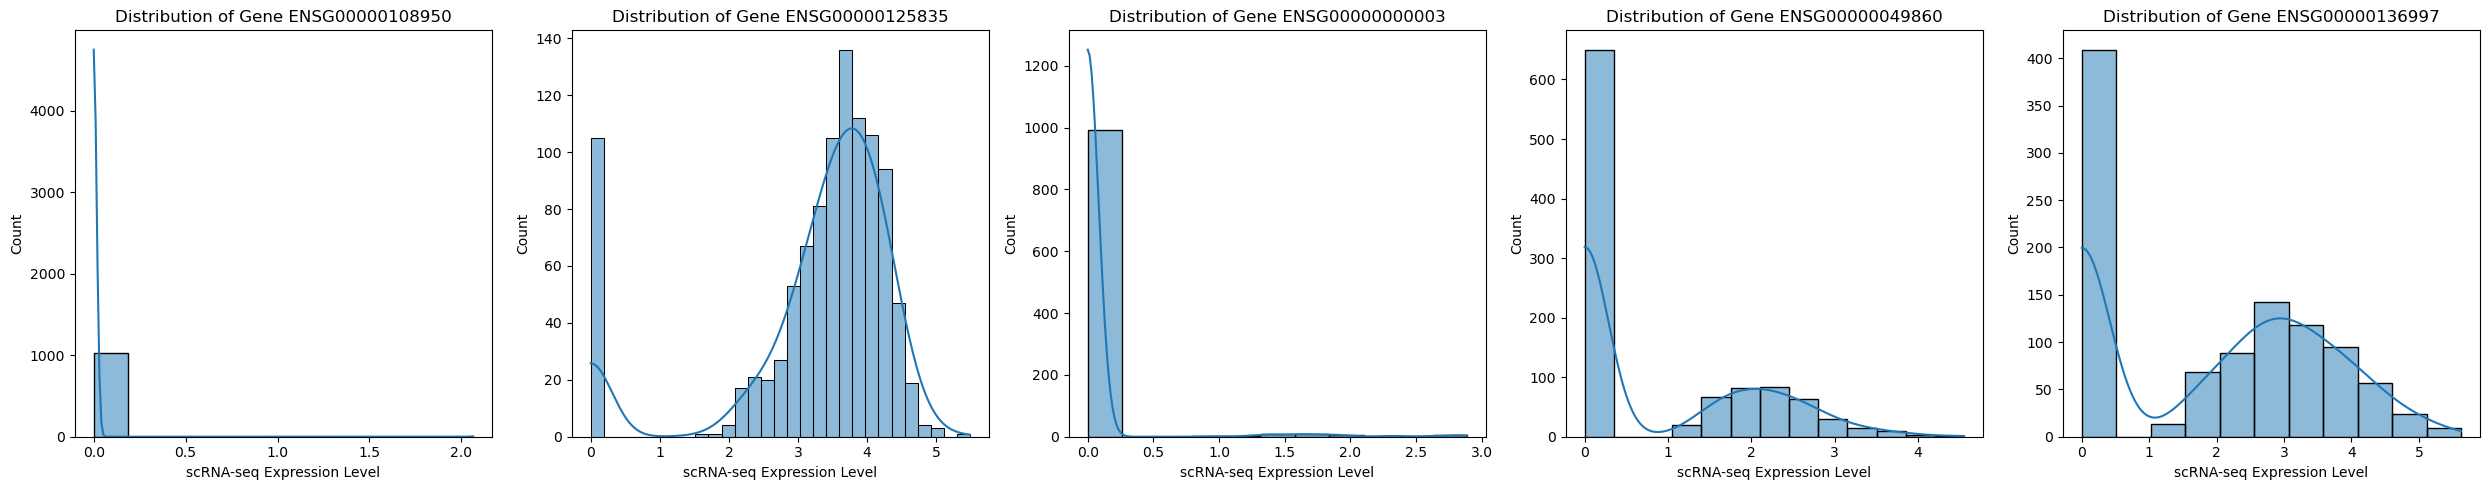

In [8]:
plot_random_genes(df, specify=['ENSG00000108950', 'ENSG00000125835', 'ENSG00000000003', 'ENSG00000049860', 'ENSG00000136997'])

We can see that expression distributions vary a lot with some genes never being expressed and others with expression profiles that are different.  
Scales of expression values vary quite a lot too, using a Normalization technique may be useful in the future.  

When taking a look at the target variable, we saw previously that it was a highly **unbalanced problem** :

In [9]:
def plot_chunk_targets(ad_object, n_chunks=5):
    memory = set()
    fig, axes = plt.subplots(1, n_chunks, figsize=(5 * n_chunks, 5), sharey=True)  # Create subplots

    for i in range(n_chunks):
        df, ids = get_annotated_chunk(ad_object, row_memory=memory)
        memory.update(ids)

        sns.barplot(x=df['tissue'].value_counts().index, y=df['tissue'].value_counts(), ax=axes[i], 
                    hue=df['tissue'].value_counts().index, legend=False, palette="viridis")
        
        axes[i].set_xticklabels(df['tissue'].value_counts().index, rotation=90)
        axes[i].set_xlabel('Tissues')
        axes[i].set_title(f'Chunk {i+1}')
        
        if i == 0:
            axes[i].set_ylabel('Count') 

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2058/1733934301.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(df['tissue'].value_counts().index, rotation=90)
/tmp/ipykernel_2058/1733934301.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(df['tissue'].value_counts().index, rotation=90)
/tmp/ipykernel_2058/1733934301.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(df['tissue'].value_counts().index, rotation=90)
/tmp/ipykernel_2058/1733934301.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(df['tissue'].value_counts().index, rotation=90)
/tmp/ipykernel_2058/1733934301.py:12: Us

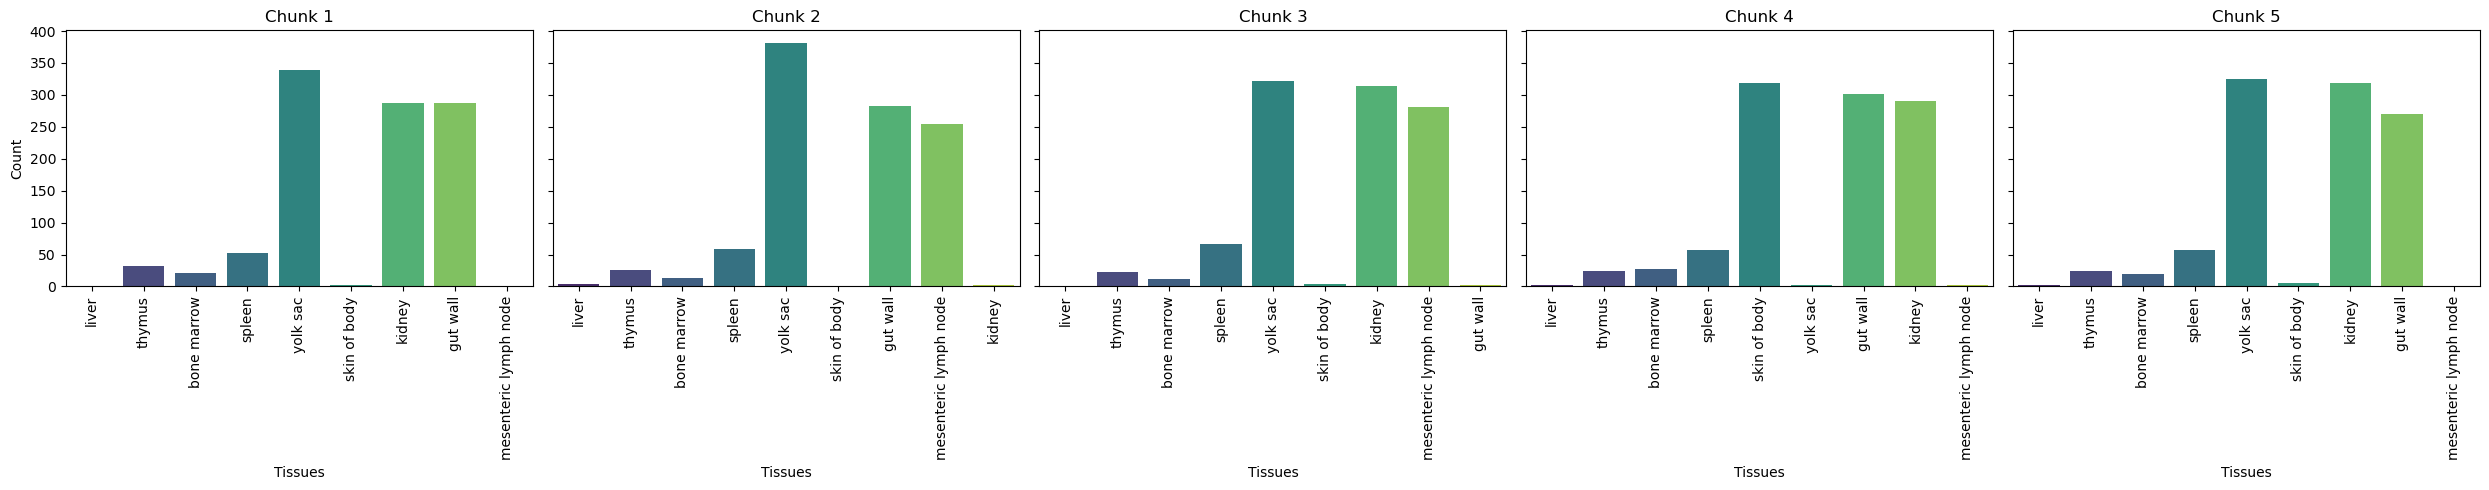

In [10]:
plot_chunk_targets(dataset_AnnData)

We will need to keep that unbalanceness in mind when training our ML models.  

One other thing we might want to take a look at is the weither or not there are a lot of genes which are never expressed in our dataset.  
If so, we can remove them to ligthen our feature matrix.

#### **I.A.2 - Dimensionality reduction**

First things first, there are too many genes (features), let's use dimensionality reduction techniques otherwise we will surely run into the curse of dimensionality.  

The goal is to find a suitable method that better summarizes our data. We will test methods on our toy chunk of data. 

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from umap import UMAP

In [12]:
def plot_data(df, target='tissue', dims=(0,1)):
    columns = list(df.columns)
    scatt = sns.scatterplot(data=df, x=columns[dims[0]], y=columns[dims[1]], hue=target)
    sns.move_legend(scatt, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

def get_embeddings(df, transformer, target={'tissue':-1}):
    transformed = transformer.fit_transform(df.iloc[:,:list(target.values())[0]])
    new_df = pd.DataFrame(transformed, columns=['Component ' + str(i) for i in range(transformed.shape[1])])
    new_df = pd.concat([new_df, df[list(target.keys())[0]]], axis=1)
    return new_df

In [13]:
# PCA 
pca = PCA(n_components=2)
pca_df = get_embeddings(df, pca)

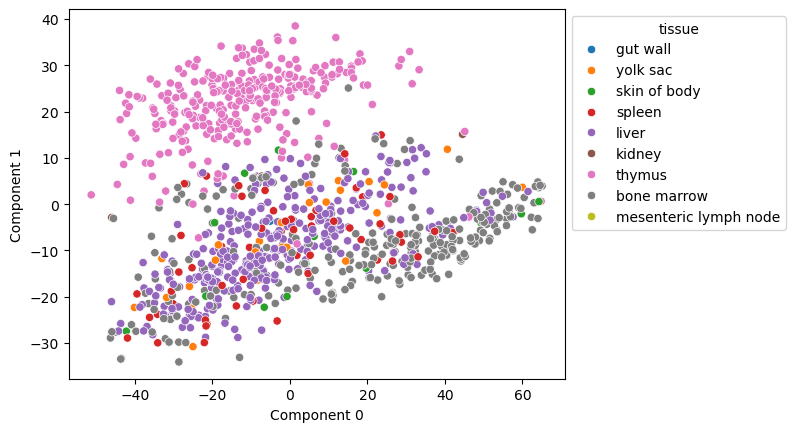

In [14]:
plot_data(pca_df, dims=(0,1))

In [15]:
# Isomap
isomap = Isomap(n_components=2)
iso_df = get_embeddings(df, isomap)

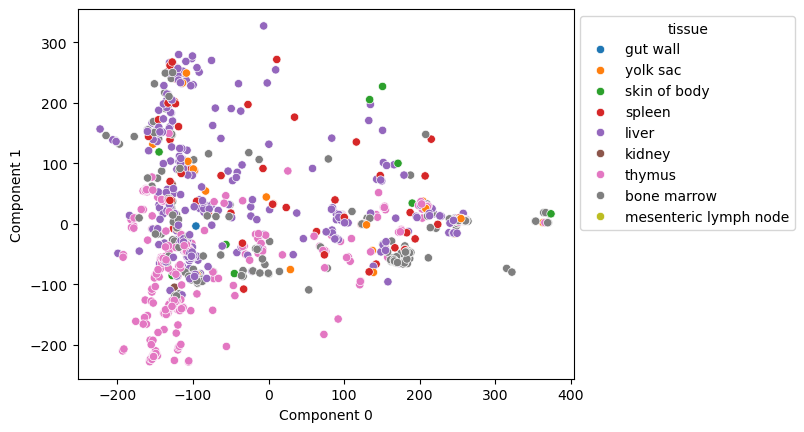

In [16]:
plot_data(iso_df, dims=(0,1))

In [17]:
# t-SNE
tsne = TSNE(n_components=2, random_state=seed)
tsne_df = get_embeddings(df, tsne)

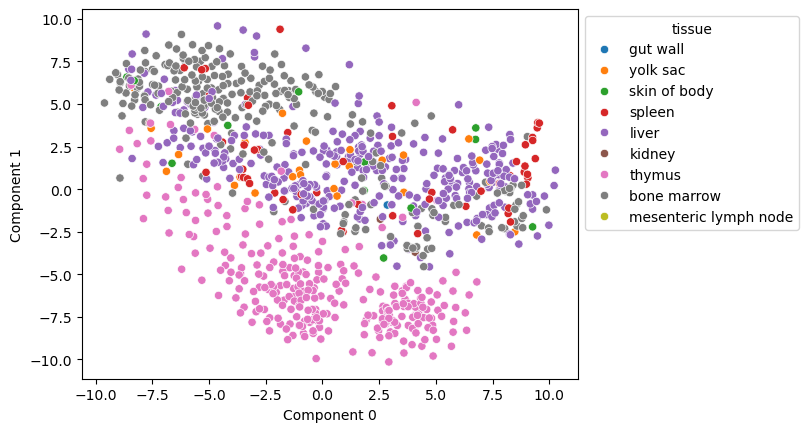

In [18]:
plot_data(tsne_df,dims=(0,1))

In [19]:
# UMAP
umap = UMAP(n_components=2, random_state=seed)
umap_df = get_embeddings(df, umap)

/home/phalafail/miniconda3/envs/ML_DL/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


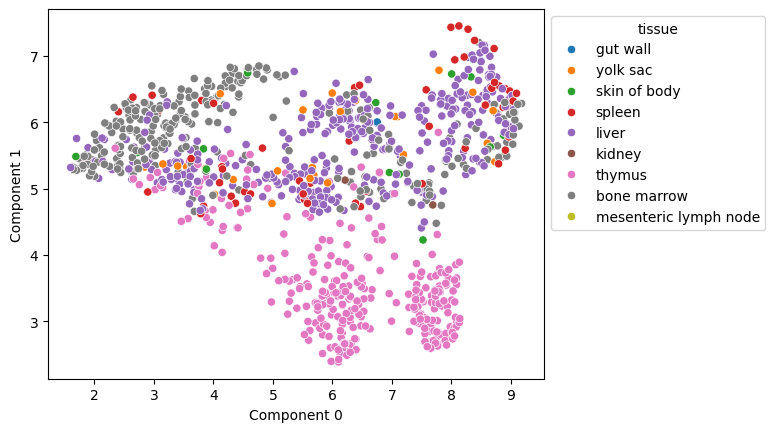

In [20]:
plot_data(umap_df)

It seems like, except for the thymus class, we are going to have difficulties seperating classes as other tissues seem to blend in one group when plotted using embeddings. However, we only are looking at two dimensions. For simplicity, let's estimate how many dimensions may be useful to represent our data using PCA.

In [21]:
pca = PCA()
pca_df = get_embeddings(df, pca)

There are 1024 components.
To explain 15.0% of variance we need : 7 dimensions.
To explain 33.0% of variance we need : 115 dimensions.
To explain 50.0% of variance we need : 262 dimensions.
To explain 66.0% of variance we need : 433 dimensions.
To explain 95.0% of variance we need : 593 dimensions.


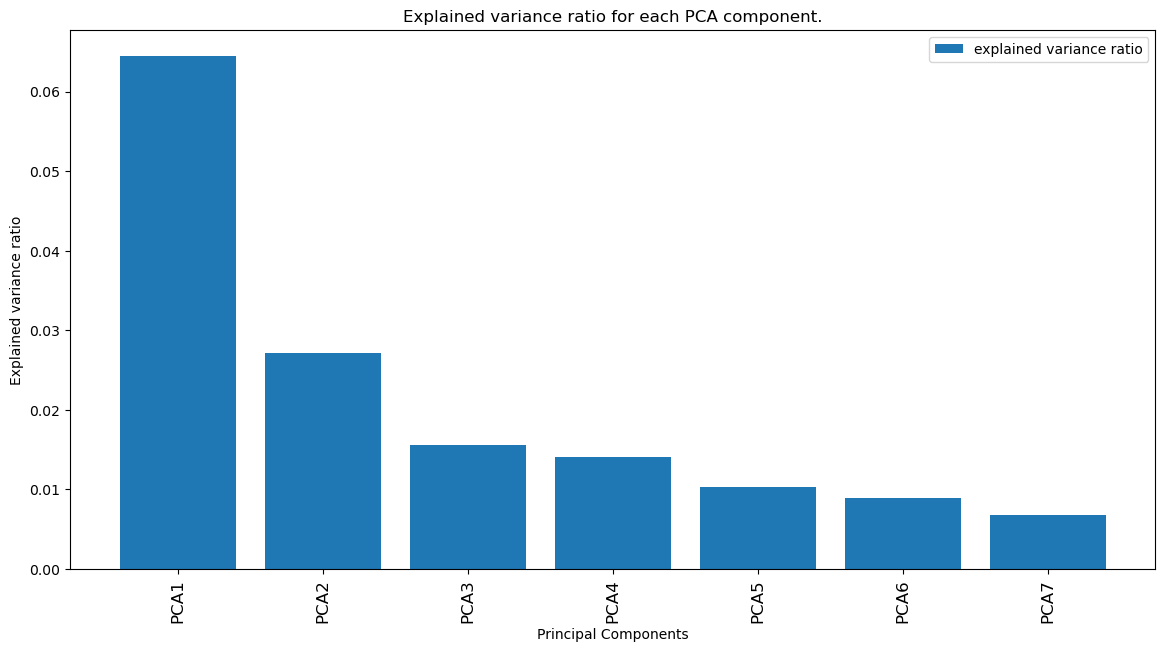

In [22]:
components = [f'PCA{i+1}' for i in range(len(pca.components_))]
print(f"There are {len(components)} components.")
exp_var = pca.explained_variance_ratio_
cum_exp_var = [np.sum(exp_var[0:i]) for i in range(1,len(exp_var)+1)]
def how_many_dims(cum_var, ratio, start=0):
    if start == 0:
        d = len([i for i in range(len(cum_var)) if cum_var[i] <= ratio])
        print(f'To explain {ratio*100}% of variance we need : {d} dimensions.')
    else:
        d = start + len([i for i in range(start - 1, len(cum_var[start-1:])) if cum_var[i] <= ratio])
        print(f'To explain {ratio*100}% of variance we need : {d} dimensions.')
    return d
d_15 = how_many_dims(cum_exp_var, 0.15)
d_33 = how_many_dims(cum_exp_var, 0.33, start=d_15)
d_50 = how_many_dims(cum_exp_var, 0.5, start=d_33)
d_66 = how_many_dims(cum_exp_var, 0.66, start=d_50)
d_95 = how_many_dims(cum_exp_var, 0.95, start=d_66)

plt.figure(figsize=(14,7))
plt.bar(components[:d_15], exp_var[:d_15], label='explained variance ratio')
plt.xlabel('Principal Components')
plt.xticks(rotation=90, fontsize=12)
plt.ylabel('Explained variance ratio')
plt.title('Explained variance ratio for each PCA component.')
plt.legend()
plt.show()

Using the elbow technique would lead us to use 2 dimensions. However the explained variance ratio associated with only 2 dimensions is really low. This means that only these 2 dimensions will very poorly represent the data. The second issue is that if we try to explain more variability, the number of dimensions we need to keep increases quickly. We cannot choose too many because of the curse of dimensionality.
So we're in a tricky situation here.  

One solution when dealing with such High dimensionality problems is to **apply a second dimensionality reduction technique** on the embeddings of the first one used. Because UMAP often leads to qualitative embeddings, we will use the technique as our second step in dimensionality reduction.

In [23]:
umap_ = UMAP(random_state=seed, 
             metric='correlation', # Recommended for high-dimensions
             n_neighbors=5, # because we want a fine-grained representation
             min_dist=0.01, 
             n_components=10) # UMAP scales well to more than 2- dimensions, using more should help to have better representation of the data

umap_df = get_embeddings(pca_df, umap_)

/home/phalafail/miniconda3/envs/ML_DL/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


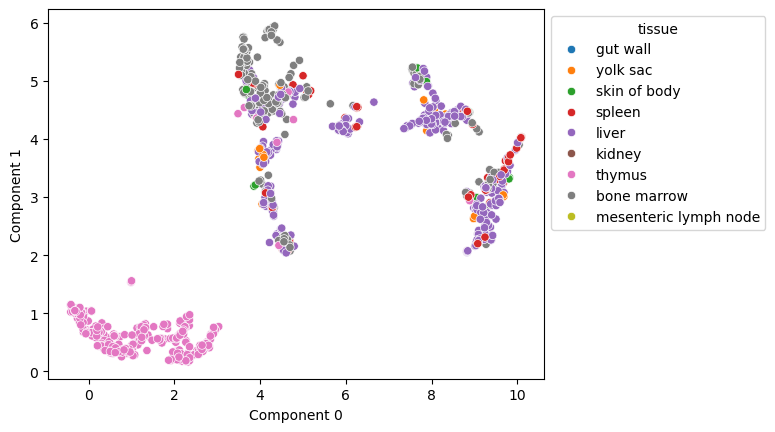

In [24]:
plot_data(umap_df)

We now have an emphasized separation of the thymus class while the original overall cluster of remaining classes seems to now be split into 4 separate ones.

Another thing we can look for before moving on to the next step, are genes that are never expressed. They could be removed from the feature matrix to reduce dimensionality. However to investigate this, we first need to quit using a toy chunk and actually define our dataset. 

We could use 20 chunks of 1024 cells for training. 8 for validation and 8 for evaluation. The scale of those numbers justifies no cross-validation protocol being used in the training sections.

In [25]:
def make_chunk_ids(ad_object, size=1024, row_memory=set()):
    all_rows = set(range(ad_object.X.shape[0]))
    possible_rows = list(all_rows - row_memory)

    ids = rd.sample(possible_rows, size)

    return ids

def get_chunk(ad_object, ids):
    Xchunk = pd.DataFrame(ad_object.chunk_X(select=ids, replace=False), columns=ad_object.var_names)
    Xchunk.reset_index(drop=True, inplace=True)
    Ychunk = pd.DataFrame(ad_object.obs['tissue'].iloc[ids], columns=['tissue'])
    Ychunk.reset_index(drop=True, inplace=True)
    return pd.concat([Xchunk, Ychunk], axis=1)

def make_sets(ad_object, train=15, val=10, test=10, size=1024):
    assert (train + val + test) * size <= ad_object.X.shape[0], "That would exceeds the number of available rows."
    sets = {'train':[], 'val':[], 'test':[]}
    memory = set()
    print('\n')
    for i in range(train):
        # print(f'Loading training chunk number {i+1}...')
        ids = make_chunk_ids(ad_object, size=size, row_memory=memory)
        memory.update(ids)
        sets['train'].append(ids)
    print('\n')
    for i in range(val):
        # print(f'Loading validation chunk number {i+1}...')
        ids = make_chunk_ids(ad_object, size=size, row_memory=memory)
        memory.update(ids)
        sets['val'].append(ids)
    print('\n')
    for i in range(test):
        # print(f'Loading test chunk number {i+1}...')
        ids = make_chunk_ids(ad_object, size=size, row_memory=memory)
        memory.update(ids)
        sets['test'].append(ids)
    return sets


In [26]:
# Make a dataset
size_chunk = 1024
n_train_chunks = 20
n_val_chunks = 8
n_test_chunks = 8
sets = make_sets(dataset_AnnData, train=n_train_chunks, val=n_val_chunks, test=n_test_chunks, size=size_chunk)

Now that we have defined our dataset. Let's remove "useless" genes.  

We could set a threshold of minimum observations needed to consider the gene, however, some tissues are extremely rare with sometime None to 1 observations per chunk. So to correctly identify a suitable threshold, we need to determine the minimum number of observations for a class in our dataset instead of per chunks. The threshold will necessarily be below that value.

How can we set this threshold ? One idea is to say that if less than 5% of the minimum number of class observations have this gene expressed then we can consider it as almost never expressed. The rationale behind this is that even if, all the observations where this gene is expressed were of the same class, and even if it was the less present class of the dataset, less than 5% means that it is not at all a representative gene expression for this class, thus we can suppose that other genes might be more useful to identify this class.

In [27]:
for i,id_list in enumerate(sets['train']):
    chunk = get_chunk(dataset_AnnData, ids=id_list)
    binary_chunk = np.where(chunk.iloc[:,:-1] != 0, 1, 0)
    if i == 0:
        S = np.sum(binary_chunk, axis=0)
        classes_counts = chunk['tissue'].value_counts()
    else:
        S += np.sum(binary_chunk, axis=0)
        classes_counts += chunk['tissue'].value_counts()

percentage = 0.05
min_obs = np.ceil(0.05*np.min(classes_counts))
# List of "never" expressed genes in training set
never_expressed = [col for i,col in enumerate(features) if S[i] <= min_obs]

print('\nOver the whole training set, here is the cardinality for each class :')
print(classes_counts)
print(f'\nThus the actual minimum of observations is {np.min(classes_counts)}.')
print(f'`nWe will use 5% of that value for thresholding : {min_obs}.')
print(f'\nThere are {len(never_expressed)} genes which are either never expressed or which are expressed at most only {min_obs} times.')


Over the whole training set, here is the cardinality for each class :
tissue
liver                    6716
bone marrow              5558
thymus                   5937
spleen                   1239
yolk sac                  500
skin of body              423
kidney                     44
mesenteric lymph node      41
gut wall                   22
Name: count, dtype: int64

Thus the actual minimum of observations is 22.
`nWe will use 5% of that value for thresholding : 2.0.

There are 10269 genes which are either never expressed or which are expressed at most only 2.0 times.


This is significant ! We will remove these genes from our feature matrix and then recompute embeddings on remaining features !  

If we take our previous toy chunk :

In [28]:
only_expressed = [col for col in features if col not in never_expressed] + ['tissue']
def get_clean_chunk(ad_object, ids, keep=only_expressed):
    chunk = get_chunk(ad_object, ids)
    return chunk[keep]

In [29]:
new_df = df[only_expressed]
# PCA 
pca = PCA()
pca_new_df = get_embeddings(new_df, pca)


Before removing non expressed genes


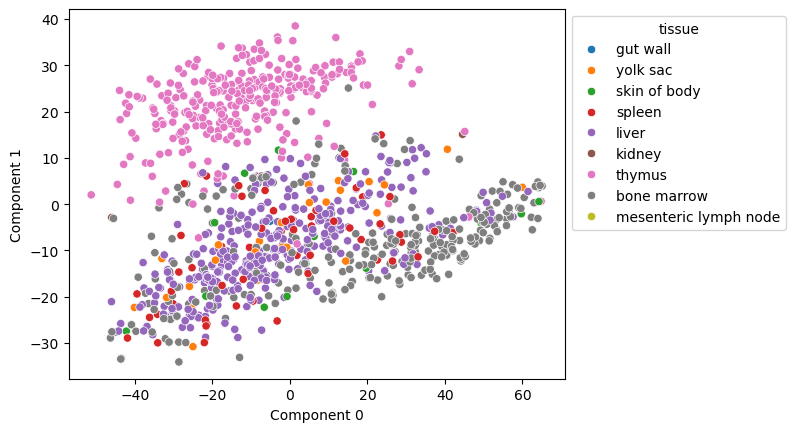


After removing non expressed genes


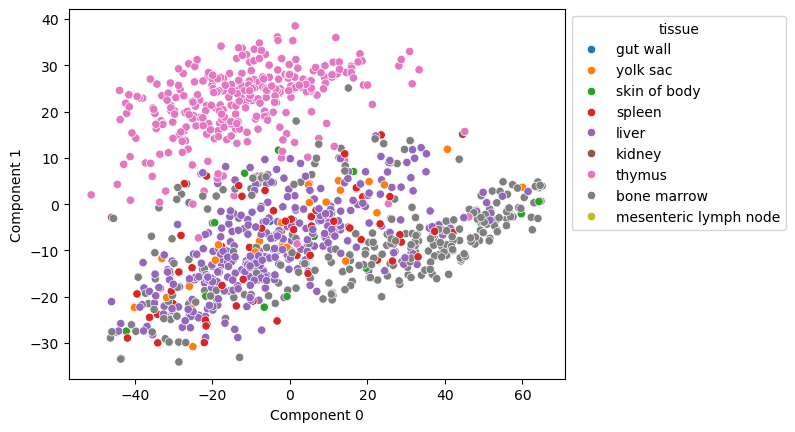

In [30]:
print('\nBefore removing non expressed genes')
plot_data(pca_df)
print('\nAfter removing non expressed genes')
plot_data(pca_new_df)

In [31]:
# UMAP
N_umap = 10
umap_ = UMAP(random_state=seed, 
             metric='correlation', # Recommended for high-dimensions
             n_neighbors=5, # because we want a fine-grained representation
             min_dist=0.01, 
             n_components=N_umap) # UMAP scales well to more than 2- dimensions, using more should help to have better representation of the data

umap_new_df = get_embeddings(pca_new_df, umap_)

/home/phalafail/miniconda3/envs/ML_DL/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Before removing non expressed genes


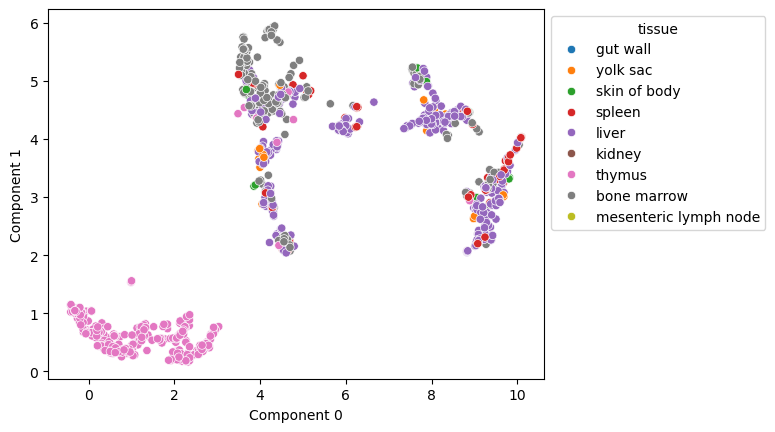


After removing non expressed genes


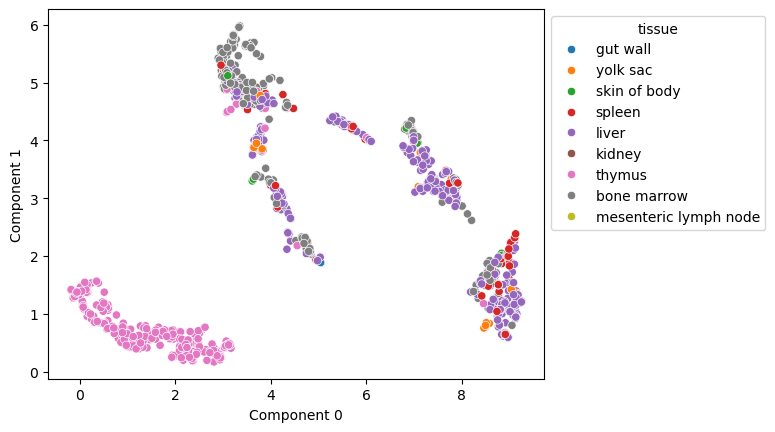

In [32]:
print('\nBefore removing non expressed genes')
plot_data(umap_df)
print('\nAfter removing non expressed genes')
plot_data(umap_new_df)

<span style="color:magenta">No major changes are observed so, as expected, removing never expressed genes does not alter data structure !</span>

We will use a succession of transformations to go from native gene features to inout model features:
1) Transform native gene features into PCA components
2) Transform all PCA components into 10 UMAP dimensions.

To ensure consistent transformations between chunks, we will fit techniques on a subset of the training (due to memory limits) set and then use the trained dimensionality reductions models for validation and test chunks.

In [33]:
pca_model = PCA()
umap_model = UMAP(random_state=seed, 
             metric='correlation',
             n_neighbors=5,
             min_dist=0.01, 
             n_components=N_umap)

# UMAP training results in an error in the jupyter notebook (memory usage) with 20 chunks, by diminuishing to 8 it's okay
n_chunks = 8
chunk_list = []
tissues = []
for i in range(n_chunks):
    id_list = sets['train'][i]
    chunk = get_clean_chunk(dataset_AnnData, id_list)
    chunk.reset_index(drop=True, inplace=True)
    chunk_list.append(chunk.iloc[:,:-1])
    tissues.append(pd.DataFrame(chunk.iloc[:,-1], columns=['tissue']))

print('\nStarted Concatenation..')
training_tissues = pd.concat(tissues, axis=0)
training_set = pd.concat(chunk_list, axis=0)
training_features = list(training_set.columns)
print(f'Raw training set shape : {training_set.shape}')
print(f'There are {len(training_features)} features.')

print('\nStarted fitting PCA..')
pca_model.fit(training_set)


Started Concatenation..
Raw training set shape : (8192, 22876)
There are 22876 features.

Started fitting PCA..


PCA()

In [34]:
exp_var_train = pca_model.explained_variance_ratio_
cum_exp_var_train = [np.sum(exp_var_train[0:i]) for i in range(1,len(exp_var_train)+1)]
start = 0
for r in [0.15, 0.33, 0.5, 0.66, 0.75, 0.95]:
    d = how_many_dims(cum_exp_var_train, r, start=start)
    start = d

To explain 15.0% of variance we need : 8 dimensions.
To explain 33.0% of variance we need : 415 dimensions.
To explain 50.0% of variance we need : 1045 dimensions.
To explain 66.0% of variance we need : 1870 dimensions.
To explain 75.0% of variance we need : 2501 dimensions.
To explain 95.0% of variance we need : 5226 dimensions.


We will use enough dimensions to explain 95% of variance

In [35]:
pca_features = [f'PCA{i+1}' for i in range(d)]
transformed_train_pca = pd.DataFrame(pca_model.transform(training_set)[:,:d], columns=pca_features)
print(f'There are {transformed_train_pca.shape[1]} features.')
print('\nStarted saving fitted PCA..')
with open('pca_model.pkl', 'wb') as f:
    pkl.dump(pca_model, f)

There are 5226 features.

Started saving fitted PCA..


In [36]:
print('\nStarted fitting UMAP..')
umap_model.fit(transformed_train_pca)


Started fitting UMAP..


/home/phalafail/miniconda3/envs/ML_DL/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, metric='correlation', min_dist=0.01, n_components=10, n_jobs=1, n_neighbors=5, random_state=62, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [37]:
input_features = [f'UMAP{i+1}' for i in range(N_umap)]
transformed_train = pd.DataFrame(umap_model.transform(transformed_train_pca), columns=input_features)
print(f'There are {transformed_train.shape[1]} features.')
print('\nStarted saving fitted UMAP..')
with open('umap_model.pkl', 'wb') as f:
    pkl.dump(umap_model, f)

There are 10 features.

Started saving fitted UMAP..


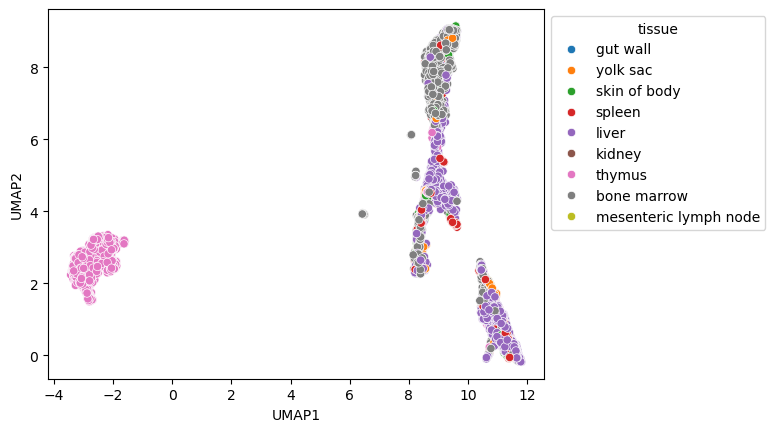

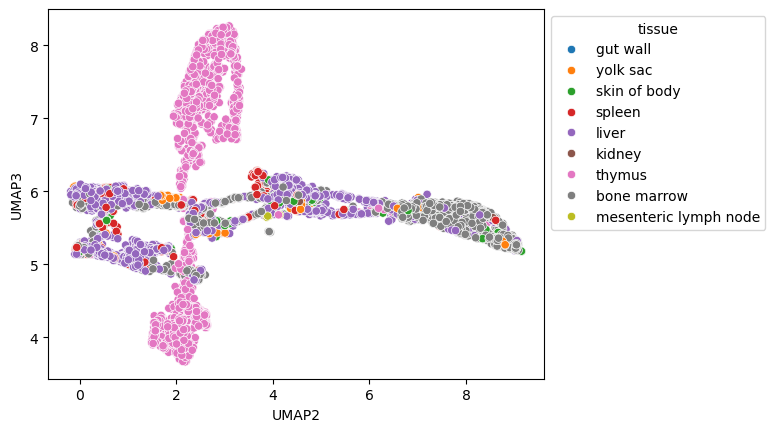

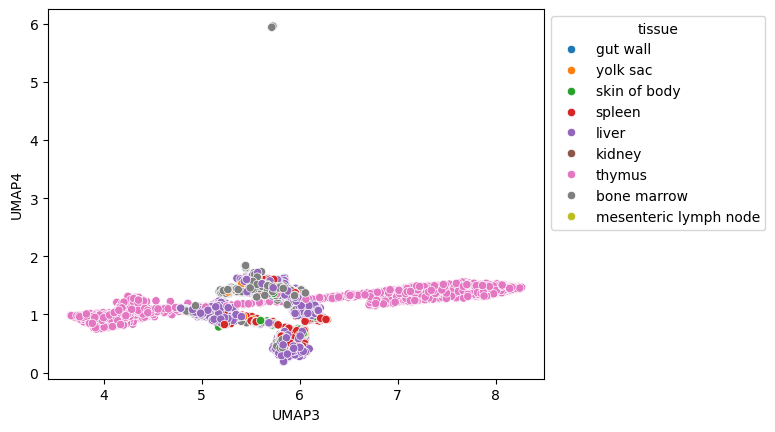

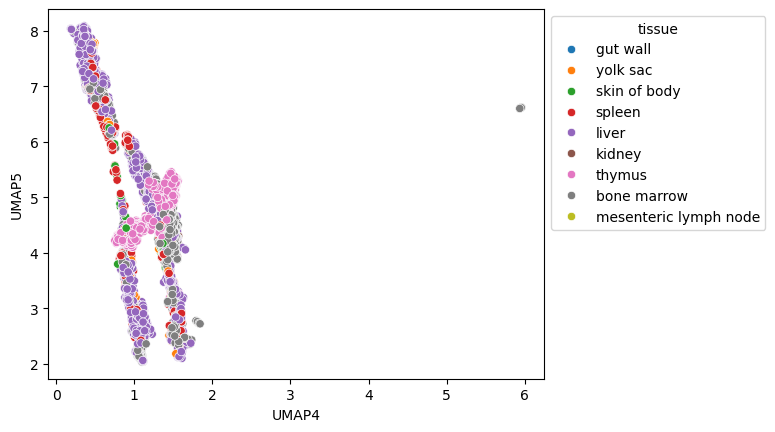

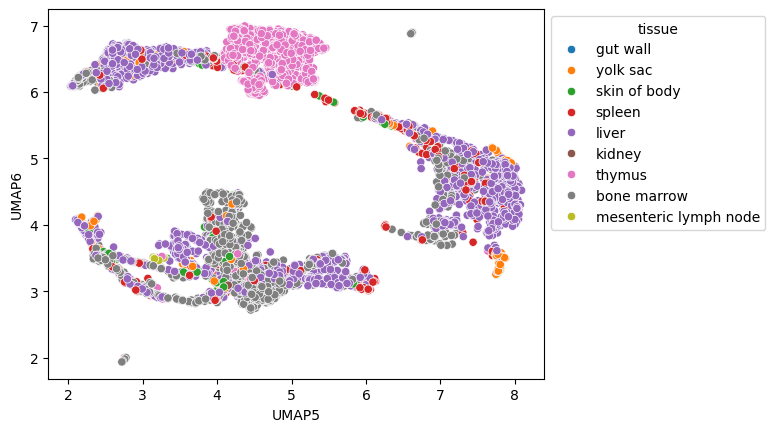

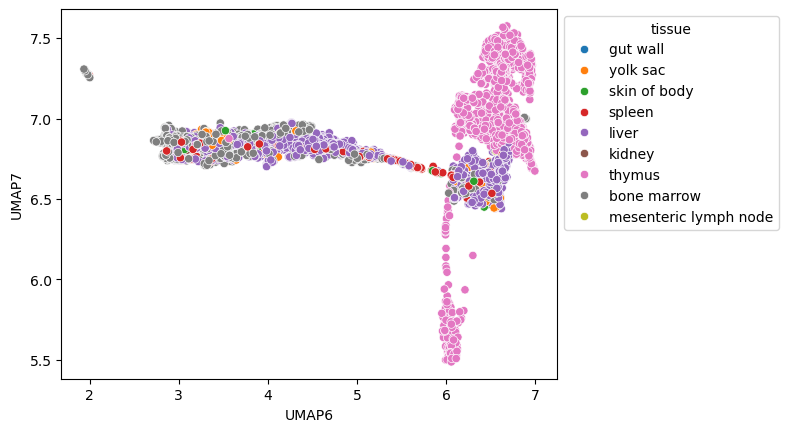

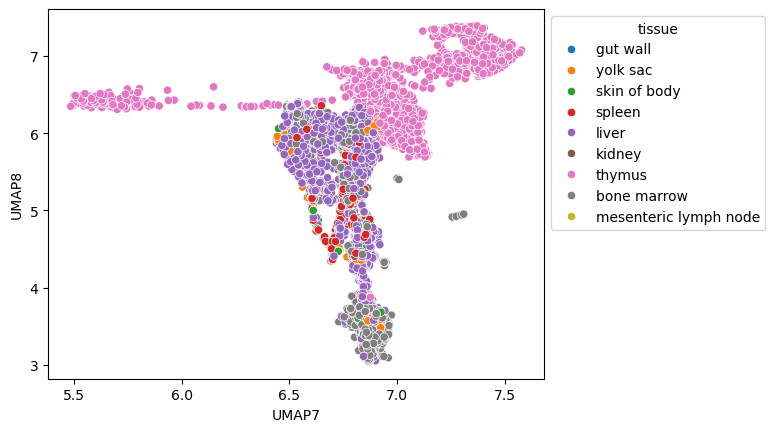

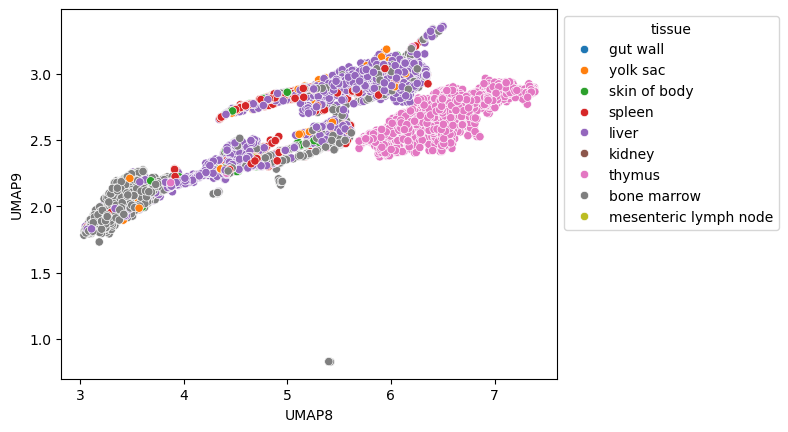

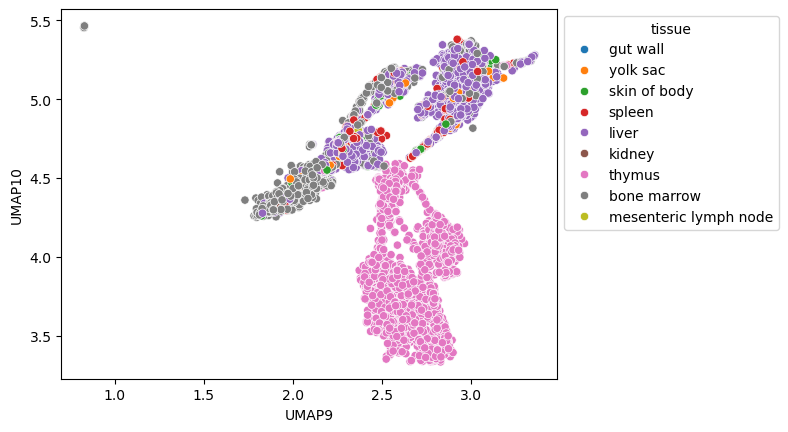

In [38]:
transformed_train.reset_index(drop=True, inplace=True)
training_tissues.reset_index(drop=True, inplace=True)
for i in range(N_umap):
    if i+1 < N_umap:
        plot_data(pd.concat([transformed_train, training_tissues], axis=1), dims=(i,i+1))

In [39]:
# Load pca and umap models
with open('pca_model.pkl', 'rb') as f:
    pca_model = pkl.load(f)
with open('umap_model.pkl', 'rb') as f:
    umap_model = pkl.load(f)

In [40]:
def ready_chunk(ad_object, ids):
    chunk = get_clean_chunk(ad_object, ids)
    chunk = chunk[training_features+['tissue']]
    pca_emb = pd.DataFrame(pca_model.transform(chunk.iloc[:,:-1])[:,:d], columns=pca_features)
    output = pd.DataFrame(umap_model.transform(pca_emb), columns=input_features)
    output.reset_index(drop=True, inplace=True)
    chunk.reset_index(drop=True, inplace=True)
    return pd.concat([output, chunk['tissue']], axis=1)

rdy_df = ready_chunk(dataset_AnnData, sets['train'][0])
print(rdy_df.shape)
print(rdy_df.head())

(1024, 11)
       UMAP1     UMAP2     UMAP3     UMAP4     UMAP5     UMAP6     UMAP7  \
0  11.287109  0.044038  5.204079  0.843234  3.795216  6.473822  6.493455   
1  -2.649641  3.078527  7.862310  1.365312  4.819865  6.396336  6.985171   
2  -2.685963  3.270654  6.690315  1.162072  5.329620  6.169209  7.135544   
3  11.405169  0.603364  5.885742  0.319262  7.922548  4.238879  6.869291   
4  11.202167  0.761643  5.925492  0.460951  7.395858  4.319210  6.818908   

      UMAP8     UMAP9    UMAP10       tissue  
0  6.039310  3.087380  5.231100  bone marrow  
1  5.875459  2.417630  3.943221       thymus  
2  5.698783  2.485171  4.510981       thymus  
3  6.018377  3.074000  5.033991        liver  
4  5.891826  2.894640  4.995008        liver  


A normalization step will be useful for some models we will try in the following section. We want to make sure that no feature gets assigned more importance simply due to its scale of values so let's apply a feature-wise noramlization step. We will not assume anything about the distribution of our features so we will be using `MinMaxScaler`. Another useful step is to convert classes to integers, it will make chunks slightly lighter and will be more suitable for model training and testing.

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
translator = {tissue:i for i,tissue in enumerate(labels)}
reverse_translator = {i:key for i,key in enumerate(translator.keys())}

def norm_ready_chunk(ad_object, ids):
    chunk = ready_chunk(ad_object, ids)
    norm_X = pd.DataFrame(scaler.fit_transform(chunk.iloc[:,:-1]), columns=chunk.columns[:-1])
    chunk['tissue'] = chunk['tissue'].map(translator)
    return pd.concat([norm_X, chunk['tissue']], axis=1)


In [42]:
norm_rdy_df = norm_ready_chunk(dataset_AnnData, sets['train'][0])
print(norm_rdy_df.shape)
print(norm_rdy_df.head())

(1024, 11)
      UMAP1     UMAP2     UMAP3     UMAP4     UMAP5     UMAP6     UMAP7  \
0  0.967022  0.023065  0.330624  0.368926  0.291722  0.896069  0.488593   
1  0.055678  0.351337  0.903935  0.706634  0.460156  0.880692  0.720411   
2  0.053303  0.372122  0.651166  0.575167  0.543950  0.835616  0.791304   
3  0.974742  0.083573  0.477641  0.029993  0.970180  0.452522  0.665780   
4  0.961468  0.100696  0.486214  0.121645  0.883602  0.468464  0.642027   

      UMAP8     UMAP9    UMAP10 tissue  
0  0.686181  0.851383  0.927384      0  
1  0.649204  0.427722  0.294497      7  
2  0.609332  0.470446  0.573505      7  
3  0.681457  0.842919  0.830522      3  
4  0.652897  0.729462  0.811365      3  


### **I.B - Models**

Our baseline model for this problem will be a `RidgeClassifier`. Then we will compare with a `LinearSVC`, a `RandomForestClassifier`, a `XGBoostClassifier` and `CatBoostClassifier`. This will allow us to compare a variety of approaches and find the best one for the task at hand.  

Howerever, we mentioned the highly unbalanced nature of our data. This requires a little thinking into how we evaluate our models. To correctly evaluate them we will be using the `f1_score` function which combines precision and recall. Computing weight classes is also necessary to take into account the unbalanced nature of the dataset.


In [43]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [44]:
def get_sets_data(ad_object, sets, normalize=True):
    dico = {}

    for key in ['train', 'val', 'test']:
        print(f'\nStarted gathering chunks for {key}.')
        chunk_list = []
        for i,id_list in enumerate(sets[key]):
            chunk = norm_ready_chunk(ad_object, id_list) if normalize else ready_chunk(ad_object, id_list)
            chunk_list.append(chunk)
        df = pd.concat(chunk_list, axis=0)
        print(f'\nRetrieved all chunks, data shape is {df.shape}')
        dico.update({key:df})
    return dico

def train_model(estimator, training_data, target='tissue'):
    columns = list(training_data.columns)
    if target in columns :
        columns.remove(target)
        
    print('\nStarted training..')
    estimator.fit(training_data[columns], training_data[target])
    print(f'\nTraining ended.')
    return estimator

def validate_model(estimator, val_data, tag, target='tissue', show_cm=False, reverse=True):
    columns = list(val_data.columns)
    if target in columns :
        columns.remove(target)

    y_hat = estimator.predict(val_data[columns])
    y_true = val_data[target]

    global_perf = f1_score(y_true, y_hat, average='micro')
    
    display = [reverse_translator[key] for key in estimator.classes_] if reverse else [key for key in estimator.classes_]
    cm = confusion_matrix(y_true, y_hat, normalize='true')
    if show_cm:
        plt.figure()
        ConfusionMatrixDisplay.from_predictions(y_true, y_hat, 
                                                labels=estimator.classes_, 
                                                display_labels=display,
                                                normalize='true',
                                                values_format='.2f',
                                                xticks_rotation='vertical')
        plt.title(f'Confusion Matrix for {tag[0]} on {tag[1]} set.')
        plt.show()

    per_class_avg_acc = np.mean([cm[i,i] for i in range(cm.shape[0])])
    
    print(f'\nPer-class average accuracy : {per_class_avg_acc}.\n\n')

    report = classification_report(y_true, y_hat, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.index = [display[i] if i < len(display) else report_df.index[i] for i in range(len(report_df.index))]
    print(report_df)
    
    print(f'\n\nOverall F1 score : {global_perf}')
    w_perf = f1_score(y_true, y_hat, average='weighted')
    print(f'Weighted F1 score :', w_perf)
    return global_perf, w_perf, per_class_avg_acc

def compare_models(models_dict, ad_object, sets_dico, normalize=True, target='tissue'):
    val_results_f1 = {model_name:0 for model_name in models_dict.keys()}
    val_results_acc_avg = {model_name:0 for model_name in models_dict.keys()}

    train_results_f1 = {model_name:0 for model_name in models_dict.keys()}
    train_results_acc_avg = {model_name:0 for model_name in models_dict.keys()}

    for model_name in models_dict.keys():
        print(f'\nTraining {model_name}..')
        model = models_dict[model_name]
        fitted_model = train_model(model, sets_dico['train'], target=target)

        print('\nEvaluation on training set..')
        _ , perf, per_class_avg_acc = validate_model(fitted_model, sets_dico['train'], tag=(model_name, 'training'), target=target)
        train_results_f1[model_name] = perf
        train_results_acc_avg[model_name] = per_class_avg_acc

        print('\nEvaluation on Validation set..')
        _ , perf, per_class_avg_acc = validate_model(fitted_model, sets_dico['val'], tag=(model_name, 'validation'), target=target)
        val_results_f1[model_name] = perf
        val_results_acc_avg[model_name] = per_class_avg_acc
    
    train_results = {'f1':train_results_f1, 'avg_acc':train_results_acc_avg}
    val_results = {'f1':val_results_f1, 'avg_acc':val_results_acc_avg}
    return train_results, val_results

def plot_model_performances(train_results, val_results):
    dico = {'Model':list(train_results['f1'].keys())+list(val_results['f1'].keys()), 
            'Weighted F1 score':list(train_results['f1'].values())+list(val_results['f1'].values()),
            'Per-class average Accuracy':list(train_results['avg_acc'].values())+list(val_results['avg_acc'].values()),
            'Set':['train']*len(list(train_results['f1'].keys())) + ['val']*len(list(train_results['f1'].keys()))
            }
    df = pd.DataFrame(dico)
    
    print(df)
    plt.figure(figsize=(10,12))
    sns.barplot(data=df, x='Model', y='Weighted F1 score', hue='Set', palette='viridis')
    max_perf = np.max(df[df['Set'] == 'val']['Weighted F1 score'])
    best_m = df[df['Weighted F1 score'] == max_perf]['Model']
    plt.axhline(max_perf, c='black',
                label=f'Best validation performance : {str(max_perf)[:5]}')
    plt.axhline(0, c='black',
                label=f'Best Model : {best_m.iloc[0]}')
    plt.legend()
    plt.xticks(rotation=45)

    plt.figure(figsize=(10,12))
    sns.barplot(data=df, x='Model', y='Per-class average Accuracy', hue='Set', palette='viridis')
    max_perf = np.max(df[df['Set'] == 'val']['Per-class average Accuracy'])
    best_m = df[df['Per-class average Accuracy'] == max_perf]['Model']
    plt.axhline(max_perf, c='black',
                label=f'Best validation performance : {str(max_perf)[:5]}')
    plt.axhline(0, c='black',
                label=f'Best Model : {best_m.iloc[0]}')
    plt.legend()
    plt.xticks(rotation=45)


In [45]:
sets_dico = get_sets_data(dataset_AnnData, sets, normalize=True)

with open('train_val_test_data.pkl', 'wb') as f:
    pkl.dump(sets_dico, f)


Started gathering chunks for train.

Retrieved all chunks, data shape is (20480, 11)

Started gathering chunks for val.

Retrieved all chunks, data shape is (8192, 11)

Started gathering chunks for test.

Retrieved all chunks, data shape is (8192, 11)


In [46]:
with open('train_val_test_data.pkl', 'rb') as f:
   sets_dico = pkl.load(f)

In [47]:
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(class_weight="balanced", classes=np.array(list(reverse_translator.keys())), y=sets_dico['train']['tissue'])

for i,c in enumerate(translator.keys()):
    print(f'\nClass {c} : {class_weights[i]}')

class_weight_dico = {i:class_weights[i] for i in reverse_translator.keys()}


Class bone marrow : 0.40941985526368396

Class gut wall : 103.43434343434343

Class kidney : 51.717171717171716

Class liver : 0.33882602077956453

Class mesenteric lymph node : 55.50135501355014

Class skin of body : 5.379563961124245

Class spleen : 1.8366065823692943

Class thymus : 0.3832837385136526

Class yolk sac : 4.551111111111111


In [48]:
%%capture
models_dict = {'RidgeClassifier':RidgeClassifier(class_weight=class_weight_dico),
               'LinearSVC':LinearSVC(class_weight=class_weight_dico),
               'RandomForestClassifier':RandomForestClassifier(n_estimators=100, class_weight=class_weight_dico, random_state=seed, n_jobs=-1),
               'CatBoostClassifier':CatBoostClassifier(n_estimators=100, class_weights=class_weight_dico, random_state=seed),
               'XGBClassifier':XGBClassifier(n_estimators=100, class_weights=class_weight_dico, random_state=seed, n_jobs=-1)}

train_results, val_results = compare_models(models_dict, dataset_AnnData, sets_dico, normalize=True, target='tissue')

                    Model  Weighted F1 score  Per-class average Accuracy  \
0         RidgeClassifier           0.585198                    0.418865   
1               LinearSVC           0.690892                    0.429240   
2  RandomForestClassifier           1.000000                    1.000000   
3      CatBoostClassifier           0.781341                    0.853275   
4           XGBClassifier           0.921691                    0.875103   
5         RidgeClassifier           0.588880                    0.362366   
6               LinearSVC           0.699518                    0.378532   
7  RandomForestClassifier           0.796725                    0.368115   
8      CatBoostClassifier           0.746267                    0.469081   
9           XGBClassifier           0.794579                    0.383407   

     Set  
0  train  
1  train  
2  train  
3  train  
4  train  
5    val  
6    val  
7    val  
8    val  
9    val  


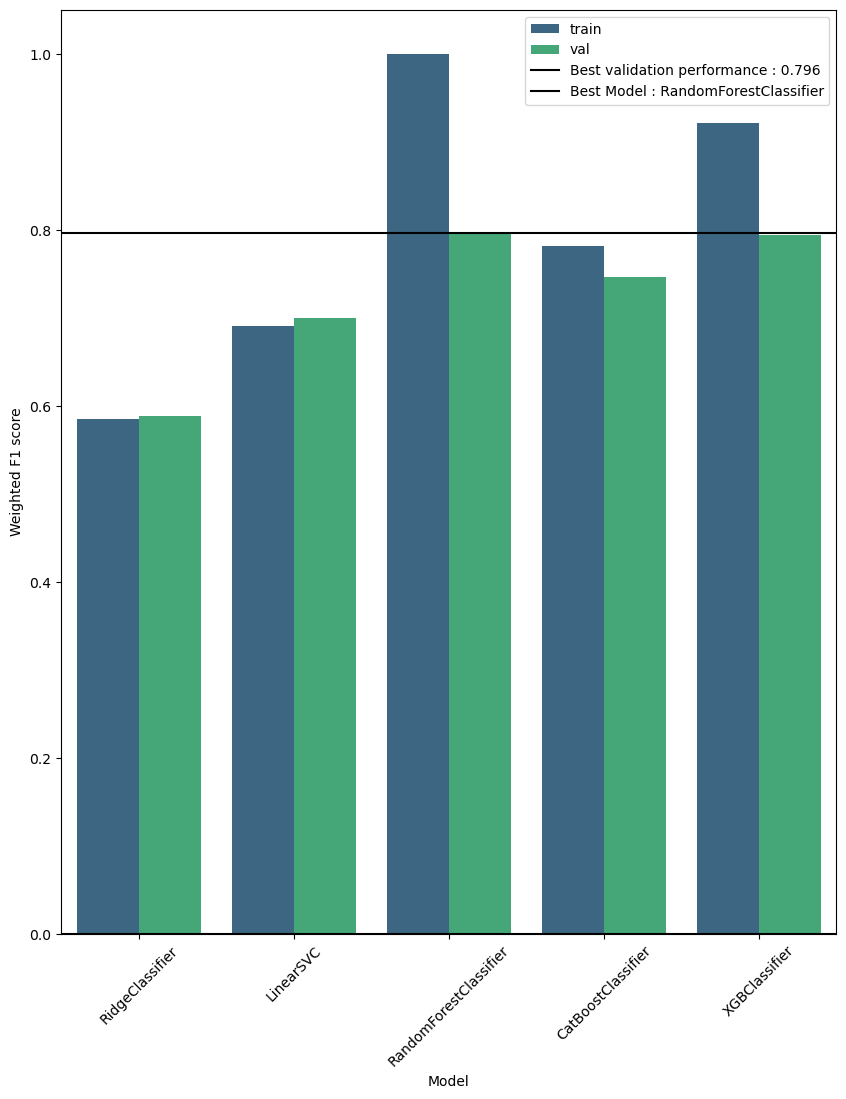

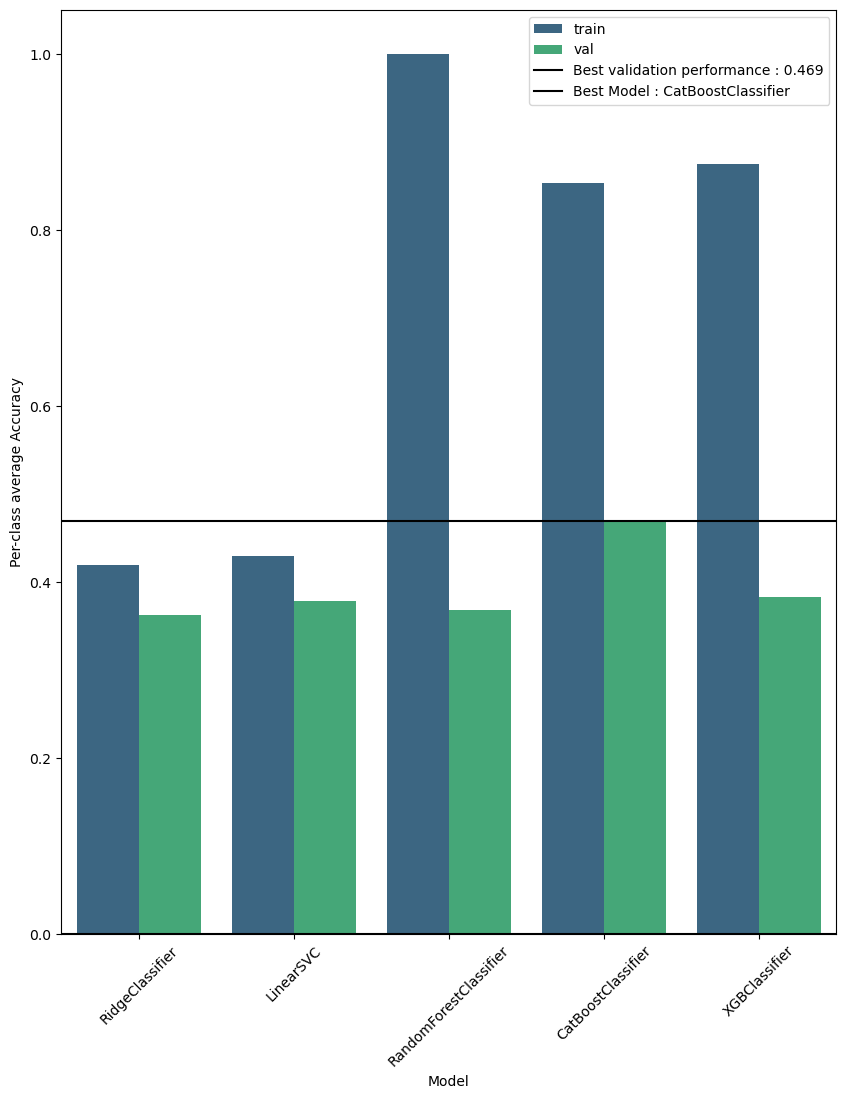

In [49]:
plot_model_performances(train_results, val_results)

<span style='color:magenta'>When comparing models based on the F1-score, `RandomForestClassifier` is the best algorithm on the validation set. However when looking at per-class average accuracy, the `CatBoostClassifier` stands out as the preferable approach. Both models could be used. Because the validation F1-score of the `CatBoostClassifier` is quite close to that of the `RandomForestClassifier` while having a much better per-class average accuracy, we will continue on working with the `CatBoostClassifier` algorithm.</span>

### **I.C - Model Optimization**

In this section we will try to improve performances using hyperparameter tuning and feature selection. 

#### **I.C.1 - Feature Selection**

First things first, we can try to see if a subset of our embedding features can be sufficient to obtain same level performances or even better ones. However we will try to maximize both the F1 score and the per-class average accuracy. To do this a common solution is to do Pareto-based feature selection. This method evaluates combinations of features by considering them Pareto-optimal: a combination is Pareto-optimal if it performs better than all others on at least one metric while not being worse on any other metric.

In [50]:
def get_pareto_indices(perf_list):
    # to identify indices of Pareto-optimal combinations
    perf_array = np.array(perf_list)
    is_pareto = np.ones(perf_array.shape[0], dtype=bool)
    for i, point in enumerate(perf_array):
        is_pareto[i] = not np.any(
            np.all(perf_array >= point, axis=1) & np.any(perf_array > point, axis=1)
        )
    return np.where(is_pareto)[0]


def select_features(estimator, training_data, val_data, target='tissue', min_improvement=1e-4):
    columns = list(training_data.columns)
    columns.remove(target)
    perf_history = []
    pareto_front = []
    kept = []
    best_model = None
    n_features = 1
    old_best_score = -np.inf
    
    while True:
        # Create combinations of features
        combinations = [kept + [col] for col in columns if col not in kept]
        if not combinations:
            break

        perf_list = []
        model_list = []

        # Train and evaluate models for each combination
        for comb in combinations:
            print(f"Evaluating combination: {comb}")
            fitted_model = train_model(estimator, training_data[comb + [target]])
            _, f1_score, avg_acc = validate_model(fitted_model, val_data[comb + [target]], tag=('CatBoostClassifier', 'val'), target=target)
            perf_list.append((f1_score, avg_acc))  # Append multi-objective performance
            model_list.append(fitted_model)
            perf_history.append((comb, f1_score, avg_acc))

        # Find Pareto-optimal combinations
        pareto_indices = get_pareto_indices(perf_list)
        pareto_combinations = [combinations[i] for i in pareto_indices]
        pareto_models = [model_list[i] for i in pareto_indices]

        # rank Pareto-optimal solutions using scalarization
        scalarized_scores = [perf_list[i][0] + perf_list[i][1] for i in pareto_indices]
        best_pareto_index = np.argmax(scalarized_scores)

        # Check for improvement
        best_comb = pareto_combinations[best_pareto_index]
        best_f1, best_avg_acc = perf_list[pareto_indices[best_pareto_index]]
        best_score = scalarized_scores[best_pareto_index]

        if pareto_front and best_score <= old_best_score:
            break  # No further improvement

        # Update the best combination and model
        kept = best_comb
        old_best_score = best_score
        best_model = pareto_models[best_pareto_index]
        pareto_front.append((best_f1, best_avg_acc))

        n_features += 1

    return kept, best_model, perf_history

def plot_feature_selection(perf_history):
    dico = {'Features':[str(t[0]) for t in perf_history],
            'Weighted F1 score': [t[1] for t in perf_history],
            'Per-class Average Accuracy': [t[2] for t in perf_history]}
    df = pd.DataFrame(dico)
    plt.figure(figsize=(12,14))
    ax = sns.barplot(data=df, y='Features', x='Weighted F1 score', palette='viridis', orient='h')
    for bars in ax.containers:
        ax.bar_label(bars)
    ax.set_xlim((0,1.1))
    plt.show()

    df = pd.DataFrame(dico)
    plt.figure(figsize=(12,14))
    ax = sns.barplot(data=df, y='Features', x='Per-class Average Accuracy', palette='viridis', orient='h')
    for bars in ax.containers:
        ax.bar_label(bars)
    ax.set_xlim((0,1.1))
    plt.show()
    

In [51]:
%%capture
base_model = CatBoostClassifier(n_estimators=100, class_weights=class_weight_dico, random_state=seed, verbose=0) #RandomForestClassifier(class_weight=class_weight_dico, random_state=seed, n_jobs=-1)

best_comb, best_model, perf_history = select_features(base_model, sets_dico['train'], sets_dico['val'], target='tissue', min_improvement=1e-4)

/tmp/ipykernel_2058/302396938.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, y='Features', x='Weighted F1 score', palette='viridis', orient='h')


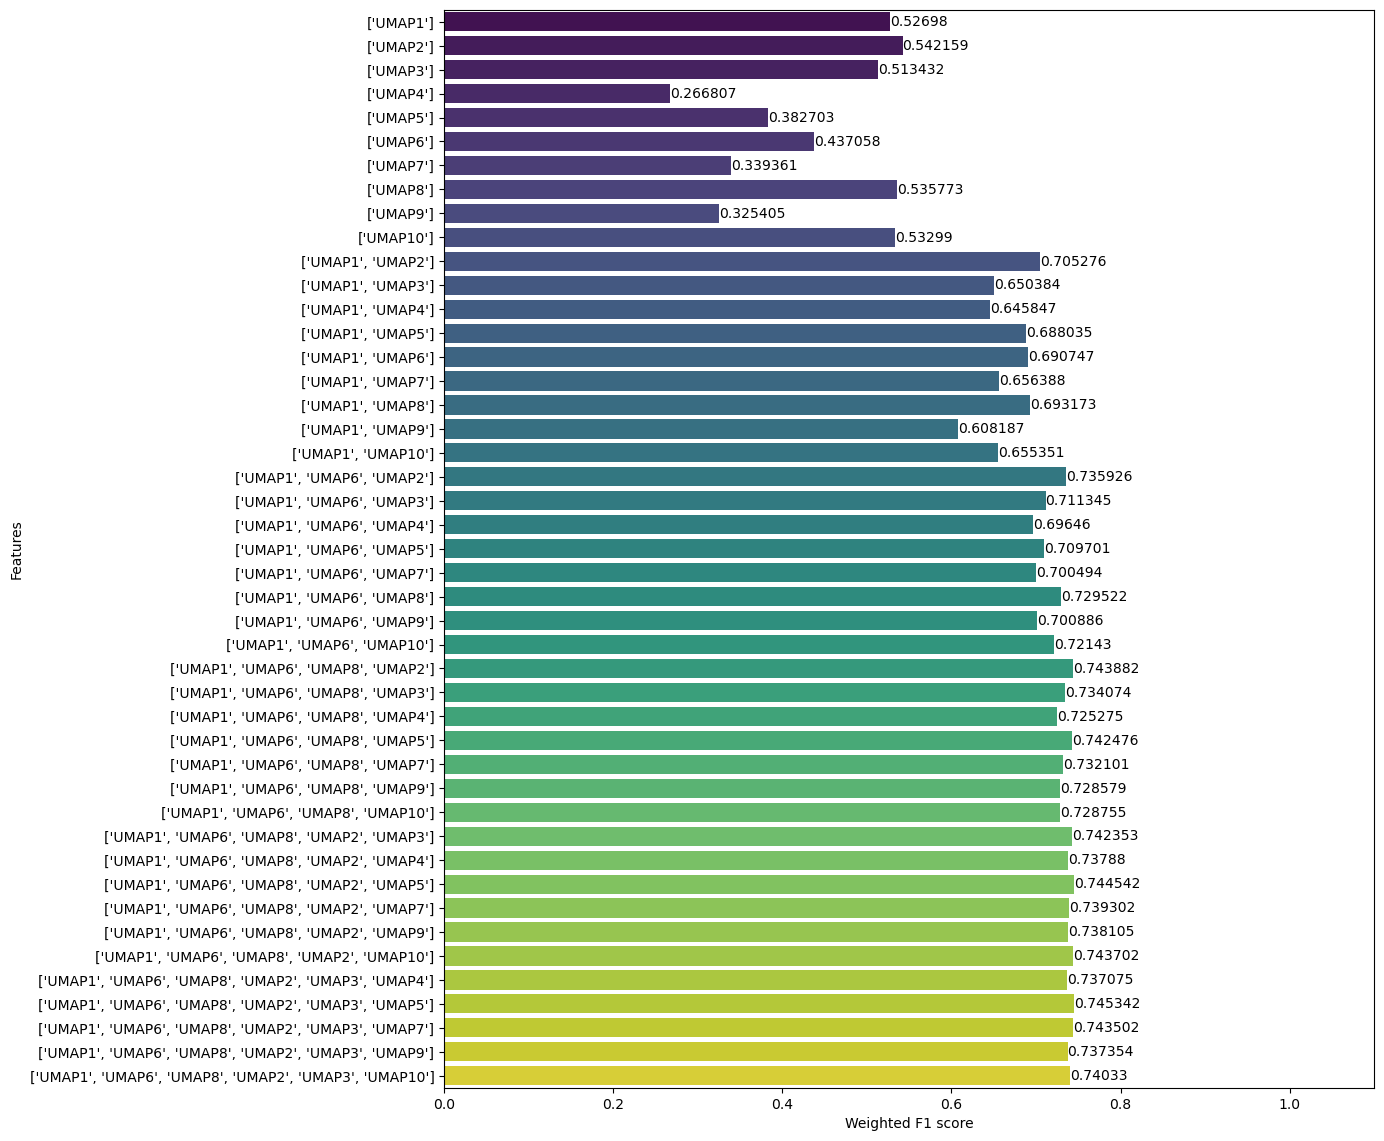

/tmp/ipykernel_2058/302396938.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, y='Features', x='Per-class Average Accuracy', palette='viridis', orient='h')


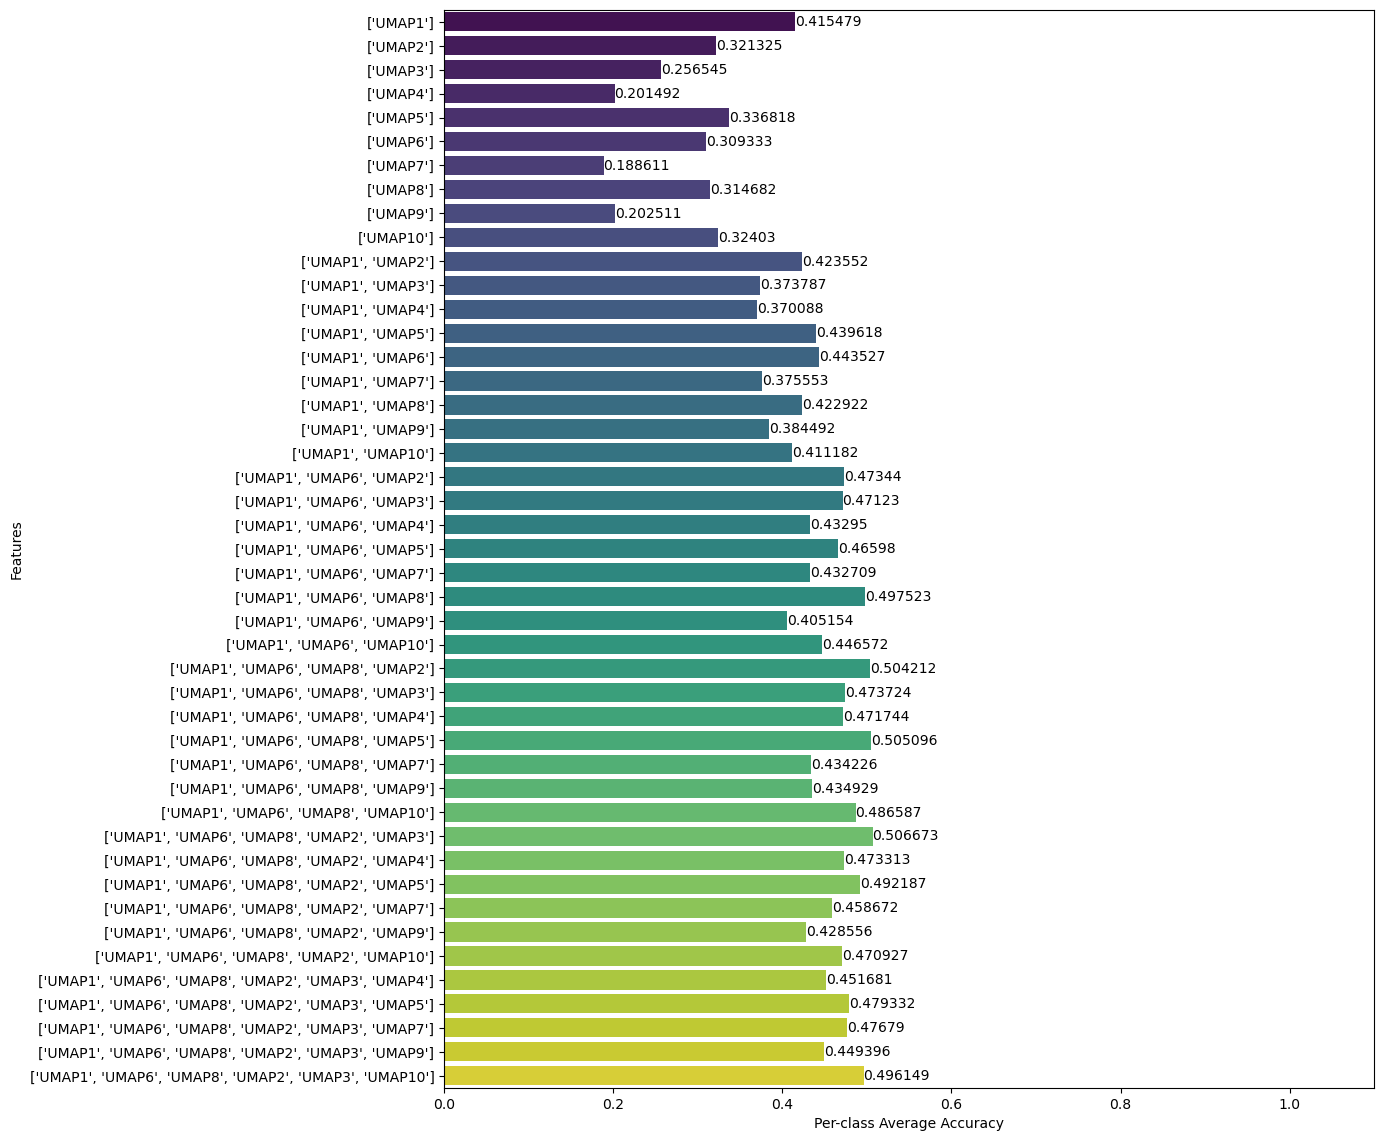

Best combination : ['UMAP1', 'UMAP6', 'UMAP8', 'UMAP2', 'UMAP3']


In [52]:
plot_feature_selection(perf_history)
print(f'Best combination : {best_comb}')

Another thing to look for is weither or not interactions features might be helpful. </span>

In [53]:
def add_interactions(data, target='tissue'):
    columns = list(data.columns)
    columns.remove(target)

    dico = {}
    for col1 in columns:
        for col2 in columns:
            if col1 != col2:
                name = col1[0] + col1[-1] + 'x' + col2[0] + col2[-1]
                alt_name = col2[0] + col2[-1] + 'x' + col1[0] + col1[-1]
                if name not in dico.keys() and alt_name not in dico.keys() :
                    dico.update({name:np.array(data[col1]) * np.array(data[col2])})
    
    df = pd.DataFrame(dico)
    data.reset_index(drop=True, inplace=True)
    return pd.concat([data[columns], df, data[target]], axis=1)

In [54]:
%%capture
base_model = CatBoostClassifier(n_estimators=100, class_weights=class_weight_dico, random_state=seed, verbose=0) #RandomForestClassifier(class_weight=class_weight_dico, random_state=seed, n_jobs=-1)

train_data_w_interactions = add_interactions(sets_dico['train'])
val_data_w_interactions = add_interactions(sets_dico['val'])

best_comb_int, best_model_int, perf_history_int = select_features(base_model, train_data_w_interactions, val_data_w_interactions, target='tissue', min_improvement=1e-4)

In [55]:
print(f'\nThe best combination is : {best_comb_int}')
print(f'New best performance : {[t[1] for t in perf_history_int if t[0] == best_comb_int][0]}')
print(f'New best performance : {[t[2] for t in perf_history_int if t[0] == best_comb_int][0]}')
diff_F1 = [t[1] for t in perf_history_int if t[0] == best_comb_int][0] - [t[1] for t in perf_history if t[0] == best_comb][0]
print(f'Difference with previous best F1: {diff_F1}')

diff_acc = [t[2] for t in perf_history_int if t[0] == best_comb_int][0] - [t[2] for t in perf_history if t[0] == best_comb][0]
print(f'Difference with previous best Per-class average accuracy: {diff_acc}')


The best combination is : ['U5xU8', 'U1xU8', 'U2xU7', 'U1xU5', 'U3xU5']
New best performance : 0.7499030976335305
New best performance : 0.5167137140609788
Difference with previous best F1: 0.007549861019405912
Difference with previous best Per-class average accuracy: 0.010040563491093613


In [56]:
if diff_F1 < 0 and diff_acc < 0:
    best_comb_int = best_comb

print(f'Features kept for future steps : {best_comb_int}')

Features kept for future steps : ['U5xU8', 'U1xU8', 'U2xU7', 'U1xU5', 'U3xU5']



#### **I.C.2 - Hyperparameter tuning**

Now that we know that we cannot hope for better performances with this given set of features, we'll try to optimize the model's performances using hyperparameter tuning.

In [95]:
%%capture
import optuna

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 300)
    max_depth = trial.suggest_int("max_depth", 4, 12)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 0.3)
    l2_leaf_reg = trial.suggest_loguniform("l2_leaf_reg", 1e-4, 10)
    bootstrap_type = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    subsample = trial.suggest_uniform("subsample", 0.5, 1.0) if bootstrap_type == "Bernoulli" else None
    class_weights = trial.suggest_categorical("class_weights", [class_weight_dico])
    metric = trial.suggest_categorical("eval_metric", ["MultiClass"])
    verbose = trial.suggest_int("verbose", 0, 0)

    model = CatBoostClassifier(
        iterations=n_estimators,
        depth=max_depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        bootstrap_type=bootstrap_type,
        subsample=subsample,
        class_weights=class_weights,
        eval_metric=metric,
        verbose=verbose,
        random_seed=seed)

    fitted_model = train_model(model, train_data_w_interactions[best_comb_int + ['tissue']], target='tissue')

    _, f1, per_class_avg_acc = validate_model(fitted_model,
                                                val_data_w_interactions[best_comb_int + ['tissue']],
                                                target='tissue',
                                                tag=('CatBoostClassifier', 'val'))

    return f1, per_class_avg_acc

# Create a multi-objective study
study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(objective, n_trials=20, n_jobs=-1)

# Access results
best_trials = study.best_trials
for trial in best_trials:
    print(f"Trial #{trial.number}")
    print(f"F1 Score: {trial.values[0]}")
    print(f"Per-class Average Accuracy: {trial.values[1]}")
    print(f"Params: {trial.params}")

In [96]:
trials = study.best_trials[0]

print("F1 score: {}".format(trial.values[0]))
print("Per-class average accuracy: {}".format(trial.values[1]))
print("Best hyperparameters: {}".format(trial.params))

print(f'\nPerformance difference with default parameters (F1-score): {trial.values[0] - [t[1] for t in perf_history if t[0] == best_comb][0]}')
print(f'\nPerformance difference with default parameters (Per-class average accuracy): {trial.values[1] - [t[2] for t in perf_history if t[0] == best_comb][0]}')

F1 score: 0.7586576384227354
Per-class average accuracy: 0.4922737059952398
Best hyperparameters: {'n_estimators': 126, 'max_depth': 8, 'learning_rate': 0.27197139243819785, 'l2_leaf_reg': 0.17877325767588612, 'bootstrap_type': 'MVS', 'class_weights': {0: 0.40941985526368396, 1: 103.43434343434343, 2: 51.717171717171716, 3: 0.33882602077956453, 4: 55.50135501355014, 5: 5.379563961124245, 6: 1.8366065823692943, 7: 0.3832837385136526, 8: 4.551111111111111}, 'eval_metric': 'MultiClass', 'verbose': 0}

Performance difference with default parameters (F1-score): 0.016304401808610813

Performance difference with default parameters (Per-class average accuracy): -0.01439944457464537


<span style="color:magenta"> Performance improvement is incredibly small, it seems as though we have reached the performance ceilling with these features and model. It is now time to test the model on our test set !</span>

### **I.D - Testing the model**

In [97]:
best_model = CatBoostClassifier(**trial.params)

test_data_w_interactions = add_interactions(sets_dico['test'])

fitted_model = train_model(best_model, train_data_w_interactions[best_comb_int+['tissue']], target='tissue')


Started training..



Training ended.


<Figure size 640x480 with 0 Axes>

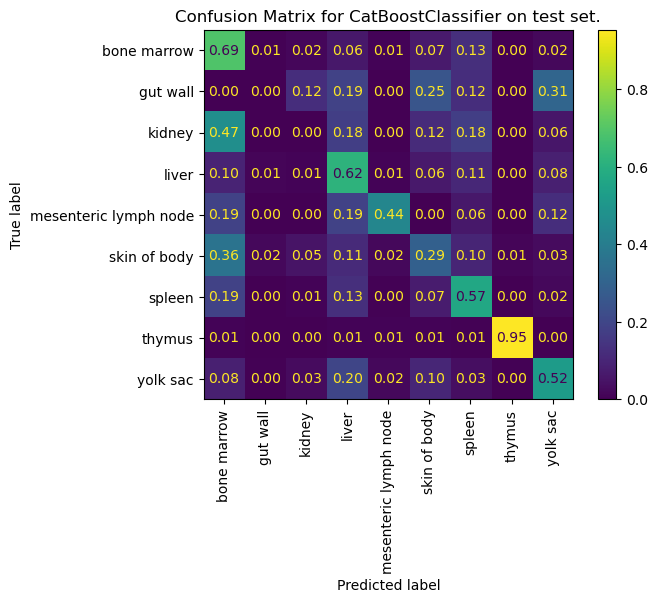


Per-class average accuracy : 0.4543707386372067.


                       precision    recall  f1-score      support
bone marrow             0.767054  0.692834  0.728058  2191.000000
gut wall                0.000000  0.000000  0.000000    16.000000
kidney                  0.000000  0.000000  0.000000    17.000000
liver                   0.859579  0.617880  0.718960  2774.000000
mesenteric lymph node   0.093333  0.437500  0.153846    16.000000
skin of body            0.092308  0.293706  0.140468   143.000000
spleen                  0.313747  0.571717  0.405154   495.000000
thymus                  0.997313  0.953747  0.975044  2335.000000
yolk sac                0.262899  0.521951  0.349673   205.000000
accuracy                0.719971  0.719971  0.719971     0.719971
macro avg               0.376248  0.454371  0.385689  8192.000000
weighted avg            0.807825  0.719971  0.752085  8192.000000


Overall F1 score : 0.719970703125
Weighted F1 score : 0.7520847548300439


In [98]:
_ , perf, avg_acc = validate_model(fitted_model, test_data_w_interactions[best_comb_int+['tissue']], target='tissue', tag=('CatBoostClassifier', 'test'), show_cm=True)

In [99]:
from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    test_data_w_interactions['tissue'],
    fitted_model.predict_proba(test_data_w_interactions[best_comb_int]),
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.96


<span style="color:magenta">We can see that the model learned how to identify thymus, liver and bone marrow quite well. This was to be expected as they correspond to predominant classes in the dataset. The model is worst than a random classifer when it comes to predicting minority classes. Especially the **model is incapable** of predicting gut wall and kidney extracted cells.</span>

One common solution when working on unbalanced datasets is to use resampling techniques to create balanced version of the training set.
In the following section we will explore such techniques and try to improve model performances.

### **II - Resampling and data-augmentation techniques**

There are two major ways to resample a dataset, either by over-sampling samples from minority classes or by under-sampling majority classes. 
The [imbalanced-learn](https://imbalanced-learn.org/stable/index.html) is a library that implements a lot of imbalance-correction algorithms. In particular we will focus on SMOTE-based algorithms [(Synthetic Minority Oversampling Technique)](https://arxiv.org/pdf/1106.1813#page=6.73). The goal of this algorithm is to generate new samples by using k-nearest neighbors to choose in which direction of the feature space the new, synthetic observtion shall be created in. 

Many different variants of this algorithm are available in the library. We will try some of them and see if they lead to better performances.

In [100]:
from imblearn.over_sampling import SMOTE, SVMSMOTE, BorderlineSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN

Since future datasets will be balanced, we need to modify the parameters of our models accordingly.

In [101]:
best_params_balanced = trial.params.copy()
best_params_balanced['class_weights'] = None

In [102]:
train_class_counts = train_data_w_interactions[best_comb_int+['tissue']]['tissue'].value_counts()
max_count = np.max(train_class_counts)
major_class = train_class_counts[train_class_counts == max_count].index[0]
to_resample = {label:max_count for label in labels if label != major_class}

def over_sample(over_sampler, df, target_col):
    X_res, Y_res = over_sampler.fit_resample(df, target_col)
    res_df = pd.concat([pd.DataFrame(X_res, columns=df.columns), pd.DataFrame(Y_res, columns=target_col.columns)], axis=1)
    print(res_df.columns)
    return res_df

def train_val_with_oversampling(over_sampler, train_df, train_target_col, val_df, val_target_col, parameters):
    res_train = over_sample(over_sampler, train_df, train_target_col)
    m = CatBoostClassifier(**parameters)

    fitted_m = train_model(m, res_train, target='tissue')
    _ , perf_m, avg_acc = validate_model(fitted_m, pd.concat([val_df, val_target_col], axis=1), target='tissue', tag=('CatBoostClassifier', 'test'), show_cm=True)

    micro_roc_auc_ovr = roc_auc_score(val_target_col,
                                    fitted_m.predict_proba(val_df),
                                    multi_class="ovr",
                                    average="micro")

    print(f"Micro-averaged one-vs-rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

    return fitted_m, perf_m, avg_acc

/home/phalafail/miniconda3/envs/ML_DL/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Index(['U5xU8', 'U1xU8', 'U2xU7', 'U1xU5', 'U3xU5', 'tissue'], dtype='object')

Started training..

Training ended.


<Figure size 640x480 with 0 Axes>

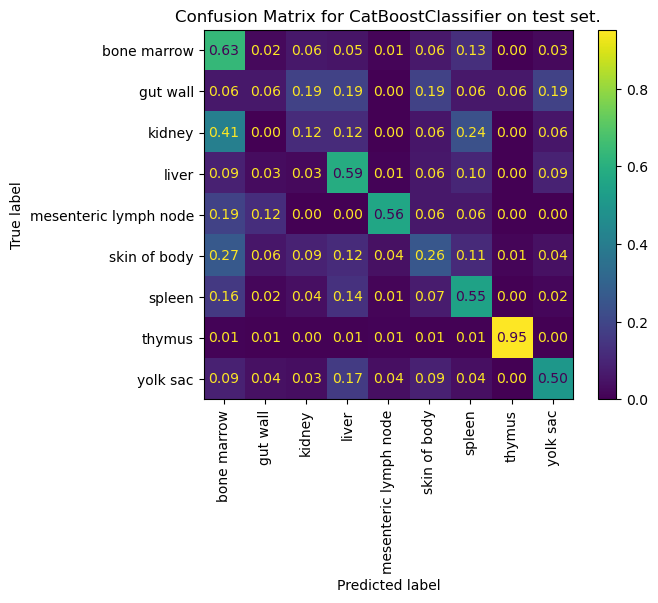


Per-class average accuracy : 0.46934829788486315.


                       precision    recall  f1-score      support
bone marrow             0.771031  0.631675  0.694431  2191.000000
gut wall                0.005464  0.062500  0.010050    16.000000
kidney                  0.007605  0.117647  0.014286    17.000000
liver                   0.865252  0.587960  0.700150  2774.000000
mesenteric lymph node   0.087379  0.562500  0.151261    16.000000
skin of body            0.087264  0.258741  0.130511   143.000000
spleen                  0.309443  0.549495  0.395924   495.000000
thymus                  0.996858  0.951178  0.973482  2335.000000
yolk sac                0.238426  0.502439  0.323391   205.000000
accuracy                0.690918  0.690918  0.690918     0.690918
macro avg               0.374302  0.469348  0.377054  8192.000000
weighted avg            0.809735  0.690918  0.734932  8192.000000


Overall F1 score : 0.69091796875
Weighted F1 score : 0.7349316364704892
Micro-averaged 

In [103]:
sm = SMOTE(random_state=seed, n_jobs=-1)

m_SMOTE, perf_SMOTE, avg_acc_SMOTE = train_val_with_oversampling(sm, 
                                                                       train_data_w_interactions[best_comb_int], 
                                                                       train_data_w_interactions['tissue'].to_frame(), 
                                                                       test_data_w_interactions[best_comb_int], 
                                                                       test_data_w_interactions['tissue'].to_frame(), 
                                                                       best_params_balanced)

/home/phalafail/miniconda3/envs/ML_DL/lib/python3.12/site-packages/imblearn/over_sampling/_smote/filter.py:437: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Index(['U5xU8', 'U1xU8', 'U2xU7', 'U1xU5', 'U3xU5', 'tissue'], dtype='object')

Started training..

Training ended.


<Figure size 640x480 with 0 Axes>

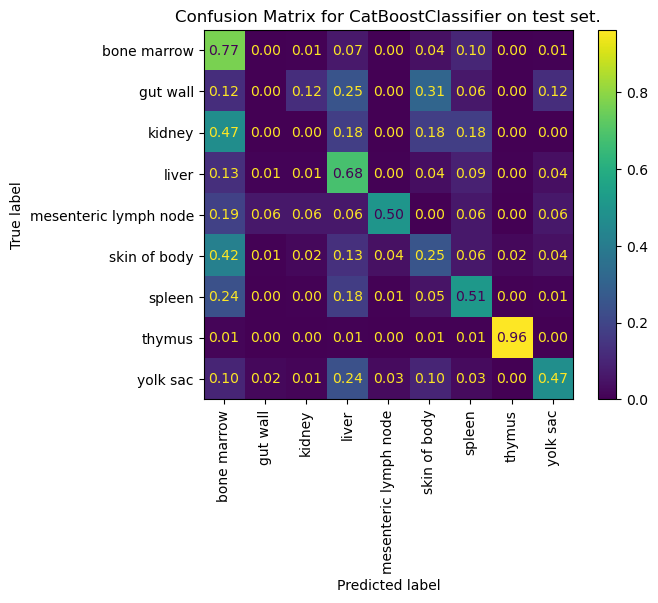


Per-class average accuracy : 0.46063499798802254.


                       precision    recall  f1-score      support
bone marrow             0.736727  0.766317  0.751230  2191.000000
gut wall                0.000000  0.000000  0.000000    16.000000
kidney                  0.000000  0.000000  0.000000    17.000000
liver                   0.853153  0.682769  0.758510  2774.000000
mesenteric lymph node   0.150943  0.500000  0.231884    16.000000
skin of body            0.120805  0.251748  0.163265   143.000000
spleen                  0.335544  0.511111  0.405124   495.000000
thymus                  0.991600  0.960600  0.975854  2335.000000
yolk sac                0.404167  0.473171  0.435955   205.000000
accuracy                0.758057  0.758057  0.758057     0.758057
macro avg               0.399215  0.460635  0.413536  8192.000000
weighted avg            0.801372  0.758057  0.774614  8192.000000


Overall F1 score : 0.758056640625
Weighted F1 score : 0.7746137883058618
Micro-averaged

In [104]:
SVMsm = SVMSMOTE(random_state=seed, n_jobs=-1)

m_SVMSMOTE, perf_SVMSMOTE, avg_acc_SVMSMOTE = train_val_with_oversampling(SVMsm,
                                                                       train_data_w_interactions[best_comb_int], 
                                                                       train_data_w_interactions['tissue'].to_frame(), 
                                                                       test_data_w_interactions[best_comb_int], 
                                                                       test_data_w_interactions['tissue'].to_frame(), 
                                                                       best_params_balanced)

/home/phalafail/miniconda3/envs/ML_DL/lib/python3.12/site-packages/imblearn/over_sampling/_smote/filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Index(['U5xU8', 'U1xU8', 'U2xU7', 'U1xU5', 'U3xU5', 'tissue'], dtype='object')

Started training..

Training ended.


<Figure size 640x480 with 0 Axes>

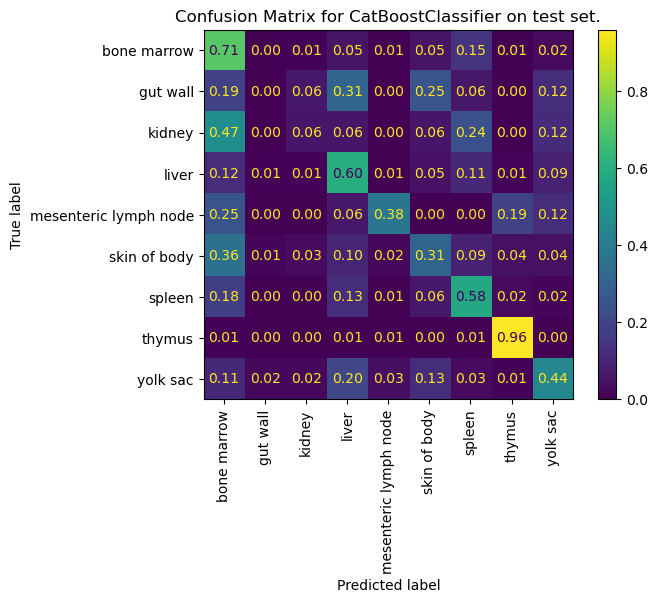


Per-class average accuracy : 0.4477369516296106.


                       precision    recall  f1-score      support
bone marrow             0.742243  0.709722  0.725618  2191.000000
gut wall                0.000000  0.000000  0.000000    16.000000
kidney                  0.016949  0.058824  0.026316    17.000000
liver                   0.870662  0.596972  0.708298  2774.000000
mesenteric lymph node   0.098361  0.375000  0.155844    16.000000
skin of body            0.123596  0.307692  0.176353   143.000000
spleen                  0.300420  0.577778  0.395301   495.000000
thymus                  0.970130  0.959743  0.964909  2335.000000
yolk sac                0.219807  0.443902  0.294023   205.000000
accuracy                0.717773  0.717773  0.717773     0.717773
macro avg               0.371352  0.447737  0.382962  8192.000000
weighted avg            0.795902  0.717773  0.743630  8192.000000


Overall F1 score : 0.7177734375
Weighted F1 score : 0.7436299540382316
Micro-averaged on

In [105]:
Bsm = BorderlineSMOTE(random_state=seed, n_jobs=-1)

m_BSMOTE, perf_BSMOTE, avg_acc_BSMOTE = train_val_with_oversampling(Bsm,
                                                                       train_data_w_interactions[best_comb_int], 
                                                                       train_data_w_interactions['tissue'].to_frame(), 
                                                                       test_data_w_interactions[best_comb_int], 
                                                                       test_data_w_interactions['tissue'].to_frame(), 
                                                                       best_params_balanced)

/home/phalafail/miniconda3/envs/ML_DL/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Index(['U5xU8', 'U1xU8', 'U2xU7', 'U1xU5', 'U3xU5', 'tissue'], dtype='object')

Started training..

Training ended.


<Figure size 640x480 with 0 Axes>

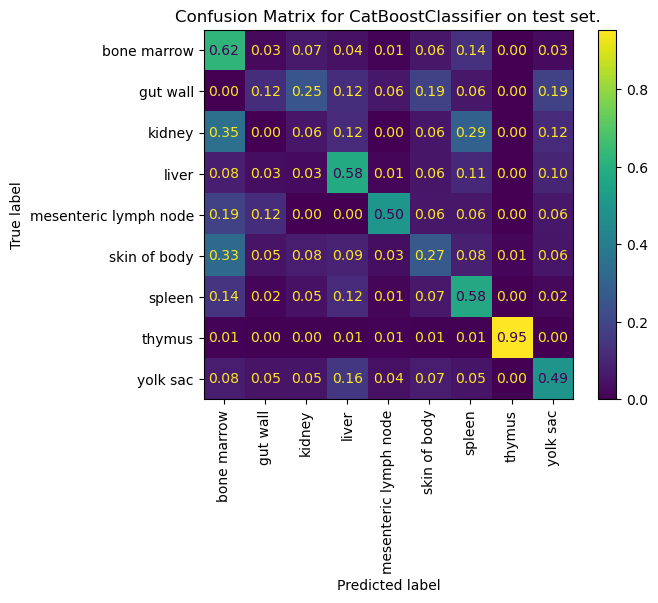


Per-class average accuracy : 0.46380466513498636.


                       precision    recall  f1-score      support
bone marrow             0.782360  0.623460  0.693929  2191.000000
gut wall                0.010695  0.125000  0.019704    16.000000
kidney                  0.003401  0.058824  0.006431    17.000000
liver                   0.880328  0.580750  0.699826  2774.000000
mesenteric lymph node   0.072727  0.500000  0.126984    16.000000
skin of body            0.095000  0.265734  0.139963   143.000000
spleen                  0.305466  0.575758  0.399160   495.000000
thymus                  0.997308  0.952034  0.974145  2335.000000
yolk sac                0.218143  0.492683  0.302395   205.000000
accuracy                0.687866  0.687866  0.687866     0.687866
macro avg               0.373936  0.463805  0.373615  8192.000000
weighted avg            0.817358  0.687866  0.734667  8192.000000


Overall F1 score : 0.6878662109375
Weighted F1 score : 0.7346671277110712
Micro-average

In [106]:
Tomek = SMOTETomek(random_state=seed, n_jobs=-1)

m_TomekSMOTE, perf_TomekSMOTE, avg_acc_TomekSMOTE = train_val_with_oversampling(Tomek, 
                                                                       train_data_w_interactions[best_comb_int], 
                                                                       train_data_w_interactions['tissue'].to_frame(), 
                                                                       test_data_w_interactions[best_comb_int], 
                                                                       test_data_w_interactions['tissue'].to_frame(), 
                                                                       best_params_balanced)

/home/phalafail/miniconda3/envs/ML_DL/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Index(['U5xU8', 'U1xU8', 'U2xU7', 'U1xU5', 'U3xU5', 'tissue'], dtype='object')

Started training..

Training ended.


<Figure size 640x480 with 0 Axes>

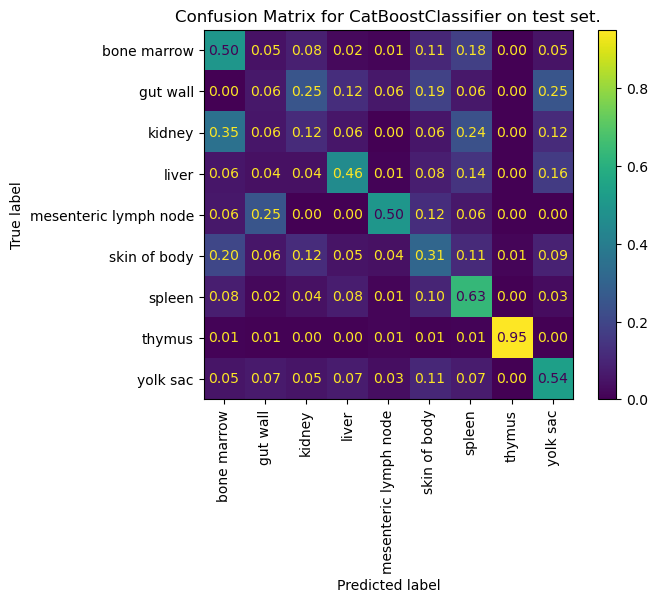


Per-class average accuracy : 0.4518149010752206.


                       precision    recall  f1-score      support
bone marrow             0.806070  0.497033  0.614907  2191.000000
gut wall                0.003676  0.062500  0.006944    16.000000
kidney                  0.005464  0.117647  0.010444    17.000000
liver                   0.911175  0.458544  0.610072  2774.000000
mesenteric lymph node   0.068376  0.500000  0.120301    16.000000
skin of body            0.075503  0.314685  0.121786   143.000000
spleen                  0.268734  0.630303  0.376812   495.000000
thymus                  0.997300  0.949036  0.972570  2335.000000
yolk sac                0.154712  0.536585  0.240175   205.000000
accuracy                0.617065  0.617065  0.617065     0.617065
macro avg               0.365668  0.451815  0.341557  8192.000000
weighted avg            0.829977  0.617065  0.679436  8192.000000


Overall F1 score : 0.6170654296875
Weighted F1 score : 0.679435677064483
Micro-averaged 

In [107]:
ENN = SMOTEENN(random_state=seed, n_jobs=-1)

m_ENNSMOTE, perf_ENNSMOTE, avg_acc_ENNSMOTE = train_val_with_oversampling(ENN, 
                                                                       train_data_w_interactions[best_comb_int], 
                                                                       train_data_w_interactions['tissue'].to_frame(), 
                                                                       test_data_w_interactions[best_comb_int], 
                                                                       test_data_w_interactions['tissue'].to_frame(), 
                                                                       best_params_balanced)

## **III - Conclusion**

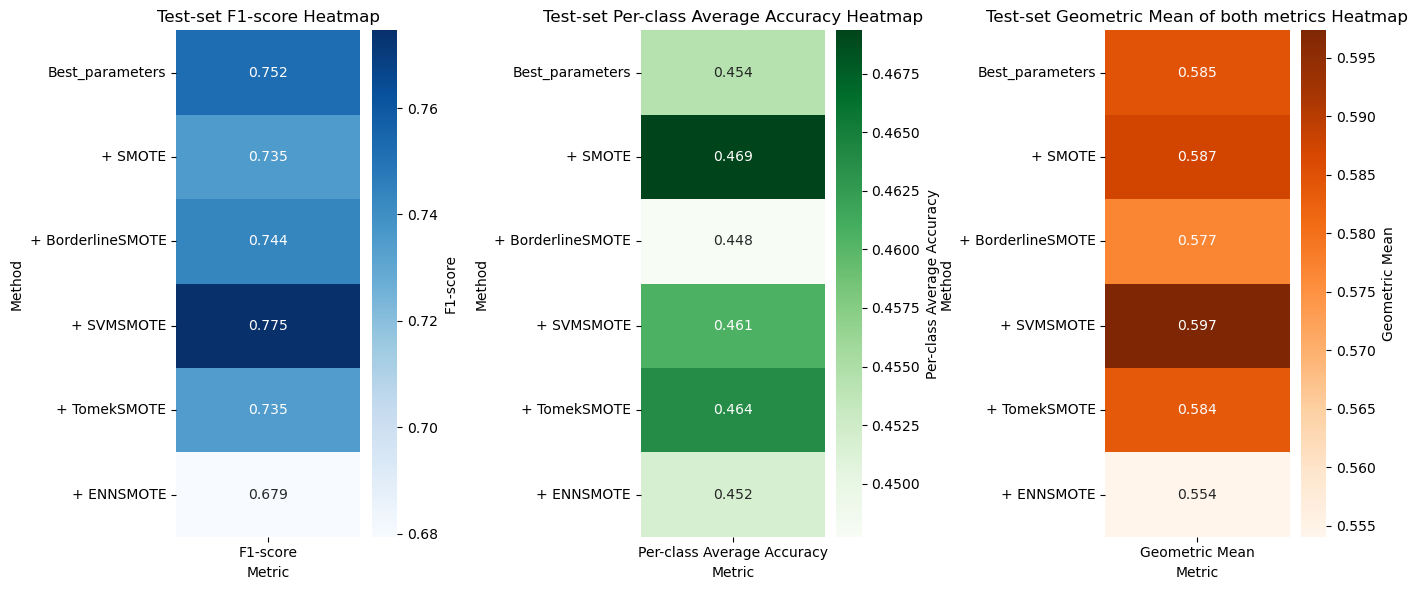

In [108]:
dico = {"Method":['Best_parameters', '+ SMOTE', '+ BorderlineSMOTE', '+ SVMSMOTE', '+ TomekSMOTE', '+ ENNSMOTE'],
        "F1-score":[perf, perf_SMOTE, perf_BSMOTE, perf_SVMSMOTE, perf_TomekSMOTE, perf_ENNSMOTE],
        "Per-class Average Accuracy":[avg_acc, avg_acc_SMOTE, avg_acc_BSMOTE, avg_acc_SVMSMOTE, avg_acc_TomekSMOTE, avg_acc_ENNSMOTE]}
df = pd.DataFrame(dico)
df["Geometric Mean"] = np.sqrt(df['F1-score']*df["Per-class Average Accuracy"])

f1_data = df.set_index("Method")["F1-score"].to_frame().T
avg_acc_data = df.set_index("Method")["Per-class Average Accuracy"].to_frame().T
geom_mean = df.set_index("Method")["Geometric Mean"].to_frame().T

fig, axes = plt.subplots(1, 3, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1, 1]})

sns.heatmap(
    f1_data.T, 
    ax=axes[0], 
    annot=True, 
    fmt=".3f", 
    cmap="Blues", 
    cbar_kws={'label': 'F1-score'})
axes[0].set_title("Test-set F1-score Heatmap")
axes[0].set_xlabel("Metric")
axes[0].set_ylabel("Method")

sns.heatmap(
    avg_acc_data.T, 
    ax=axes[1], 
    annot=True, 
    fmt=".3f", 
    cmap="Greens", 
    cbar_kws={'label': 'Per-class Average Accuracy'})
axes[1].set_title("Test-set Per-class Average Accuracy Heatmap")
axes[1].set_xlabel("Metric")
axes[1].set_ylabel("Method")

sns.heatmap(
    geom_mean.T, 
    ax=axes[2], 
    annot=True, 
    fmt=".3f", 
    cmap="Oranges", 
    cbar_kws={'label': 'Geometric Mean'})
axes[2].set_title("Test-set Geometric Mean of both metrics Heatmap")
axes[2].set_xlabel("Metric")
axes[2].set_ylabel("Method")

plt.tight_layout()
plt.show()


Results show that using an over-sampling method before training the model to balance the dataset can result in better performances than the original model obtained after Hyperparameter tuning. When looking closely, two such methods stand out : SMOTE and SVMSMOTE. These two techniques yield to best models with slightly different strengths and weaknesses : 
- SMOTE : The obtained model learned to identify at least a portion of all 9 tissues. However, when predicting a class it makes more mistakes.
- SVMSMOTE : Leads to a model that makes less mistakes overall, when it predicts a class it is usually better at predicting it than other models. However the model obtained did not at all learn how to identify gut wall and kidney cells. So it is essentially an model that got better at predicting other classes but did not learn patterns to identify the mentioned tissues.

No matter the method finally kept, the model is still worse than a random classifier for several minority classes. The difficulty arises from the data itself as we already have discussed that a lot of tissues seemed undistinguishable in embedding space. 

Using domain knowledge to target tissue specific genes could significantly help this approach. Another solution is to step up to deep learning as multiclassification can often be solved really well using such algorithms. 